In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import time
from IPython.display import display, Math, Latex

import pickle
import NestedFormula
import auxiliary_functions
import explore
import importlib
from hessian import hessian
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [2]:
importlib.reload(NestedFormula)
importlib.reload(auxiliary_functions)
importlib.reload(explore)

<module 'explore' from '/home/zybinmikhail/Documents/personal github projects/LearningFormulas/explore.py'>

## Linear combination of 3 variables and bias with standard-normally distributed coefficients

In [32]:
explore.explore()



----------------------------Exploring new formula #1----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0449, current formula \left(-11.424x_1^{-0.027} + 10.731x_2^{-0.015} + 0.915x_3^{1.071} + 0.819\right)
  Finished run #1, loss 0.04426300898194313, best loss 0.04426300898194313
  Initialization #2
  Finished run #2, loss 0.011057988740503788, best loss 0.011057988740503788
  Initialization #3
  Finished run #3, loss 7.58524076882594e-10, best loss 7.58524076882594e-10
loss is smaller than 1e-05, terminating learning process
38 seconds passed from the start, the iteration took 38 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.2181853367313319e-08
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.01343916542828083, best loss 0.01343916542828083
  Initialization #2
  Finished run #2, loss 0.0015267726266756654, best loss 0.0015267726266756654
  Initialization #3
  Finished run #3, loss 0.013873125426471233, best loss 0.0015267726266756654
  Initialization #4
  Finished run #4, loss 0.011437230743467808, best loss 0.0015267726266756654
  Initialization #5
  Finished run #5, loss 0.00028848694637417793, best loss 0.00028848694637417793
  Initialization #6
  Finished run #6, loss 0.011361205950379372, best loss 0.00028848694637417793
  Initialization #7
  Finished run #7, loss 0.012482903897762299, best loss 0.00028848694637417793
  Initialization #8
    Epoch 5000, current loss 0.00934, current formula \left(5.719x_1^{-0.029}-0.210x_2^{1.102} + 1.330x_3^{-0.024}-6.305\right)
  Finish

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.8217513293213506
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.0004741509328596294, best loss 0.0004741509328596294
  Initialization #2
  Finished run #2, loss 0.00046852396917529404, best loss 0.00046852396917529404
  Initialization #3
  Finished run #3, loss 0.000554167025256902, best loss 0.00046852396917529404
  Initialization #4
  Finished run #4, loss 2.823388856043607e-09, best loss 2.823388856043607e-09
loss is smaller than 1e-05, terminating learning process
1 minutes 49 seconds passed from the start, the iteration took 15 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.0111635002463e-07
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 7.996097672879898e-10, best loss 7.996097672879898e-10
loss is smaller than 1e-05, terminating learning process
1 minutes 51 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.000738325021205e-08
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.119, current formula \left(0.060x_1^{5.802}-9.050x_2^{-0.051}-1.181x_3^{0.991} + 9.822\right)
    Epoch 10000, current loss 0.114, current formula \left(0.059x_1^{5.951}-14.402x_2^{-0.034}-1.188x_3^{0.977} + 15.199\right)
  Finished run #1, loss 0.11366713047027588, best loss 0.11366713047027588
  Initialization #2
  Finished run #2, loss 2.2134427624109776e-08, best loss 2.2134427624109776e-08
loss is smaller than 1e-05, terminating learning process
2 minutes 32 seconds passed from the start, the iteration took 41 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.7070178810246794e-06
EXACT RECOVERY


----------------------------Exploring new formula #6----------------------------
  Initialization #1
  Finished run #1, loss 3.651099422796733e-09, best loss 3.651099422796733e-09
loss is smaller than 1e-05, terminating learning process
2 minutes 34 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.073016812444556e-07
EXACT RECOVERY


----------------------------Exploring new formula #7----------------------------
  Initialization #1
  Finished run #1, loss 0.012222030200064182, best loss 0.012222030200064182
  Initialization #2
  Finished run #2, loss 2.1197285704488422e-08, best loss 2.1197285704488422e-08
loss is smaller than 1e-05, terminating learning process
2 minutes 38 seconds passed from the start, the iteration took 3 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.166313272906507e-06
EXACT RECOVERY


----------------------------Exploring new formula #8----------------------------
  Initialization #1
  Finished run #1, loss 5.693628679637186e-09, best loss 5.693628679637186e-09
loss is smaller than 1e-05, terminating learning process
2 minutes 40 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.9255488898599943e-07
EXACT RECOVERY


----------------------------Exploring new formula #9----------------------------
  Initialization #1
  Finished run #1, loss 0.0002396345662418753, best loss 0.0002396345662418753
  Initialization #2
  Finished run #2, loss 0.0001678973058005795, best loss 0.0001678973058005795
  Initialization #3
  Finished run #3, loss 0.002253648592159152, best loss 0.0001678973058005795
  Initialization #4
  Finished run #4, loss 0.0036190208047628403, best loss 0.0001678973058005795
  Initialization #5
  Finished run #5, loss 4.4747611172013535e-10, best loss 4.4747611172013535e-10
loss is smaller than 1e-05, terminating learning process
2 minutes 52 seconds passed from the start, the iteration took 13 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.1145637650400927e-07
EXACT RECOVERY


----------------------------Exploring new formula #10----------------------------
  Initialization #1
  Finished run #1, loss 0.012512505054473877, best loss 0.012512505054473877
  Initialization #2
  Finished run #2, loss 0.011847813613712788, best loss 0.011847813613712788
  Initialization #3
  Finished run #3, loss 0.04677753150463104, best loss 0.011847813613712788
  Initialization #4
  Finished run #4, loss 2.9658236977425645e-10, best loss 2.9658236977425645e-10
loss is smaller than 1e-05, terminating learning process
3 minutes 6 seconds passed from the start, the iteration took 13 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.622096477786857e-09
EXACT RECOVERY

################################################################################
MSEs between parameters:
[1.2181853367313319e-08, 0.8217513293213506, 7.0111635002463e-07, 5.000738325021205e-08, 6.7070178810246794e-06, 3.073016812444556e-07, 3.166313272906507e-06, 1.9255488898599943e-07, 2.1145637650400927e-07, 7.622096477786857e-09]
For 9 formulas out of 10 the error is less than 1e-05.


## Linear combination of 3 squared variables and bias with standard-normally distributed coefficients

In [11]:
explore(min_power=2, max_power=2)



----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.19504092633724213, best loss 0.19504092633724213
  Initialization #2
  Finished run #2, loss 0.007013747934252024, best loss 0.007013747934252024
  Initialization #3
  Finished run #3, loss 0.009375261142849922, best loss 0.007013747934252024
  Initialization #4
  Finished run #4, loss 0.009800040163099766, best loss 0.007013747934252024
  Initialization #5
  Finished run #5, loss 1.8762023185070476e-12, best loss 1.8762023185070476e-12
loss is smaller than 0.001, terminating learning process
15 seconds passed from the start, the iteration took 15 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.69699216717033e-12
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 3.5127137743701242e-12, best loss 3.5127137743701242e-12
loss is smaller than 0.001, terminating learning process
16 seconds passed from the start, the iteration took 1 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.412026548081485e-11
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.1483605057001114, best loss 0.1483605057001114
  Initialization #2
  Finished run #2, loss 0.02518836408853531, best loss 0.02518836408853531
  Initialization #3
  Finished run #3, loss 1.3154793226943795e-11, best loss 1.3154793226943795e-11
loss is smaller than 0.001, terminating learning process
32 seconds passed from the start, the iteration took 15 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.558649565503304e-10
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 1.5556061647159503e-11, best loss 1.5556061647159503e-11
loss is smaller than 0.001, terminating learning process
33 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 4.6123866630815817e-10
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.0013860539766028523, best loss 0.0013860539766028523
  Initialization #2
  Finished run #2, loss 0.0016387712676078081, best loss 0.0013860539766028523
  Initialization #3
  Finished run #3, loss 5.024526801566953e-12, best loss 5.024526801566953e-12
loss is smaller than 0.001, terminating learning process
38 seconds passed from the start, the iteration took 5 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.520428805612953e-09
EXACT RECOVERY


----------------------------Exploring new formula #6----------------------------
  Initialization #1
  Finished run #1, loss 0.03510764613747597, best loss 0.03510764613747597
  Initialization #2
  Finished run #2, loss 0.03426942229270935, best loss 0.03426942229270935
  Initialization #3
  Finished run #3, loss 0.035176824778318405, best loss 0.03426942229270935
  Initialization #4
  Finished run #4, loss 0.023263581097126007, best loss 0.023263581097126007
  Initialization #5
    Epoch 5000, current loss 0.054, current formula \left(0.879x_1^{1.832}-8.612x_2^{-0.023} + 8.933x_3^{-0.019}-1.041\right)
    Epoch 10000, current loss 0.0535, current formula \left(0.879x_1^{1.835}-12.666x_2^{-0.016} + 12.986x_3^{-0.013}-1.041\right)
  Finished run #5, loss 0.05348413810133934, best loss 0.023263581097126007
  Initialization #6
  Finished run #6, loss 8.06729336111367e-12, best loss 8.06729336111367e-12
loss is smalle

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.1134510842483516e-10
EXACT RECOVERY


----------------------------Exploring new formula #7----------------------------
  Initialization #1
  Finished run #1, loss 0.010849709622561932, best loss 0.010849709622561932
  Initialization #2
  Finished run #2, loss 0.038911230862140656, best loss 0.010849709622561932
  Initialization #3
  Finished run #3, loss 0.009395286440849304, best loss 0.009395286440849304
  Initialization #4
  Finished run #4, loss 0.0017017177306115627, best loss 0.0017017177306115627
  Initialization #5
  Finished run #5, loss 0.03575057163834572, best loss 0.0017017177306115627
  Initialization #6
  Finished run #6, loss 0.011514522135257721, best loss 0.0017017177306115627
  Initialization #7
    Epoch 5000, current loss 0.0114, current formula \left(-5.762x_1^{-0.020} + 0.945x_2^{1.895} + 3.524x_3^{-0.011} + 3.652\right)
  Finished run #7, loss 0.011352745816111565, best loss 0.0017017177306115627
  Initialization #8
  Finished

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.36695601003672e-09
EXACT RECOVERY


----------------------------Exploring new formula #8----------------------------
  Initialization #1
  Finished run #1, loss 0.00043949144310317934, best loss 0.00043949144310317934
loss is smaller than 0.001, terminating learning process
2 minutes 48 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.306655452500273
FAILURE


----------------------------Exploring new formula #9----------------------------
  Initialization #1
  Finished run #1, loss 2.1731370175581688e-11, best loss 2.1731370175581688e-11
loss is smaller than 0.001, terminating learning process
2 minutes 50 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.782828465030533e-08
EXACT RECOVERY


----------------------------Exploring new formula #10----------------------------
  Initialization #1
  Finished run #1, loss 7.292567591465904e-12, best loss 7.292567591465904e-12
loss is smaller than 0.001, terminating learning process
2 minutes 55 seconds passed from the start, the iteration took 6 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.295644557788495e-10
EXACT RECOVERY

################################################################################
MSEs between parameters:
[6.69699216717033e-12, 7.412026548081485e-11, 3.558649565503304e-10, 4.6123866630815817e-10, 3.520428805612953e-09, 3.1134510842483516e-10, 6.36695601003672e-09, 2.306655452500273, 7.782828465030533e-08, 5.295644557788495e-10]
For 9 formulas out of 10 the error is less than 1e-05.


## Linear combination of 3 variables with powers uniformly distributed over {1, 2 ,3 ,4, 5} and standard-normally distributed coefficients

In [35]:
explore.explore(max_power=6)



----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.06304360181093216, best loss 0.06304360181093216
  Initialization #2
  Finished run #2, loss 0.004367060959339142, best loss 0.004367060959339142
  Initialization #3
  Finished run #3, loss 1.3601357019832339e-11, best loss 1.3601357019832339e-11
loss is smaller than 1e-05, terminating learning process
6 seconds passed from the start, the iteration took 6 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.667260058065235e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.08279216289520264, best loss 0.08279216289520264
  Initialization #2
  Finished run #2, loss 1.7293509289514897e-12, best loss 1.7293509289514897e-12
loss is smaller than 1e-05, terminating learning process
10 seconds passed from the start, the iteration took 4 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.1465926620855628e-10
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 7.422276226791424e-13, best loss 7.422276226791424e-13
loss is smaller than 1e-05, terminating learning process
14 seconds passed from the start, the iteration took 4 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.1858755247625855e-10
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.002982549136504531, best loss 0.002982549136504531
  Initialization #2
  Finished run #2, loss 0.033160265535116196, best loss 0.002982549136504531
  Initialization #3
  Finished run #3, loss 0.09207728505134583, best loss 0.002982549136504531
  Initialization #4
  Finished run #4, loss 0.03271259367465973, best loss 0.002982549136504531
  Initialization #5
  Finished run #5, loss 0.0027095582336187363, best loss 0.0027095582336187363
  Initialization #6
  Finished run #6, loss 2.9511610169508096e-12, best loss 2.9511610169508096e-12
loss is smaller than 1e-05, terminating learning process
36 seconds passed from the start, the iteration took 22 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.3764445208005004e-10
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0621, current formula \left(-7.449x_1^{-0.011}-0.163x_2^{3.560} + 6.996x_3^{-0.015} + 0.764\right)
  Finished run #1, loss 0.06207393482327461, best loss 0.06207393482327461
  Initialization #2
    Epoch 5000, current loss 0.0622, current formula \left(-7.718x_1^{-0.011}-0.163x_2^{3.565} + 6.194x_3^{-0.017} + 1.836\right)
  Finished run #2, loss 0.06211938336491585, best loss 0.06207393482327461
  Initialization #3
  Finished run #3, loss 1.208213824127613e-11, best loss 1.208213824127613e-11
loss is smaller than 1e-05, terminating learning process
1 minutes 25 seconds passed from the start, the iteration took 49 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.4469741119579486e-08
EXACT RECOVERY


----------------------------Exploring new formula #6----------------------------
  Initialization #1
  Finished run #1, loss 0.08188065886497498, best loss 0.08188065886497498
  Initialization #2
    Epoch 5000, current loss 0.182, current formula \left(-9.522x_1^{-0.026} + 1.402x_2^{4.533} + 2.577x_3^{0.022} + 8.277\right)
  Finished run #2, loss 0.18087251484394073, best loss 0.08188065886497498
  Initialization #3
  Finished run #3, loss 0.0822642371058464, best loss 0.08188065886497498
  Initialization #4
  Finished run #4, loss 2.086057455247259e-12, best loss 2.086057455247259e-12
loss is smaller than 1e-05, terminating learning process
2 minutes 3 seconds passed from the start, the iteration took 38 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.5023411086596232e-10
EXACT RECOVERY


----------------------------Exploring new formula #7----------------------------
  Initialization #1
  Finished run #1, loss 0.0009585803491063416, best loss 0.0009585803491063416
  Initialization #2
  Finished run #2, loss 0.016282297670841217, best loss 0.0009585803491063416
  Initialization #3
  Finished run #3, loss 0.016563350334763527, best loss 0.0009585803491063416
  Initialization #4
  Finished run #4, loss 6.829097292000708e-13, best loss 6.829097292000708e-13
loss is smaller than 1e-05, terminating learning process
2 minutes 31 seconds passed from the start, the iteration took 28 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.4865421660867923e-10
EXACT RECOVERY


----------------------------Exploring new formula #8----------------------------
  Initialization #1
  Finished run #1, loss 0.0010126919951289892, best loss 0.0010126919951289892
  Initialization #2
  Finished run #2, loss 5.297980804064295e-12, best loss 5.297980804064295e-12
loss is smaller than 1e-05, terminating learning process
2 minutes 34 seconds passed from the start, the iteration took 3 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.1178741107390318e-08
EXACT RECOVERY


----------------------------Exploring new formula #9----------------------------
  Initialization #1
  Finished run #1, loss 0.05849596858024597, best loss 0.05849596858024597
  Initialization #2
  Finished run #2, loss 0.000568809628020972, best loss 0.000568809628020972
  Initialization #3
    Epoch 5000, current loss 0.0352, current formula \left(-1.289x_1^{-0.011}-5.506x_2^{-0.024} + 0.662x_3^{3.975} + 5.457\right)
  Finished run #3, loss 0.03520870953798294, best loss 0.000568809628020972
  Initialization #4
  Finished run #4, loss 0.034622740000486374, best loss 0.000568809628020972
  Initialization #5
  Finished run #5, loss 0.0006225152174010873, best loss 0.000568809628020972
  Initialization #6
  Finished run #6, loss 5.907022267159778e-12, best loss 5.907022267159778e-12
loss is smaller than 1e-05, terminating learning process
3 minutes 3 seconds passed from the start, the iteration took 29 seconds
gro

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.363041794779213e-08
EXACT RECOVERY


----------------------------Exploring new formula #10----------------------------
  Initialization #1
  Finished run #1, loss 0.005140147637575865, best loss 0.005140147637575865
  Initialization #2
  Finished run #2, loss 1.1832983377868533e-11, best loss 1.1832983377868533e-11
loss is smaller than 1e-05, terminating learning process
3 minutes 6 seconds passed from the start, the iteration took 3 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 9.018604936760181e-07
EXACT RECOVERY

################################################################################
MSEs between parameters:
[5.667260058065235e-09, 1.1465926620855628e-10, 1.1858755247625855e-10, 3.3764445208005004e-10, 1.4469741119579486e-08, 1.5023411086596232e-10, 3.4865421660867923e-10, 1.1178741107390318e-08, 2.363041794779213e-08, 9.018604936760181e-07]
For 10 formulas out of 10 the error is less than 1e-05.


In [46]:
explore.explore(max_power=15, divide_powers_by=3)



----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.0005649023805744946, best loss 0.0005649023805744946
  Initialization #2
  Finished run #2, loss 3.363373165046757e-12, best loss 3.363373165046757e-12
loss is smaller than 1e-05, terminating learning process
3 seconds passed from the start, the iteration took 3 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.0837911044804726e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.043854933232069016, best loss 0.043854933232069016
  Initialization #2
  Finished run #2, loss 5.613911113755421e-09, best loss 5.613911113755421e-09
loss is smaller than 1e-05, terminating learning process
15 seconds passed from the start, the iteration took 12 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.233614190178222e-08
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.028962085023522377, best loss 0.028962085023522377
  Initialization #2
  Finished run #2, loss 4.988416549167596e-05, best loss 4.988416549167596e-05
  Initialization #3
  Finished run #3, loss 0.026912150904536247, best loss 4.988416549167596e-05
  Initialization #4
  Finished run #4, loss 0.14470908045768738, best loss 4.988416549167596e-05
  Initialization #5
  Finished run #5, loss 5.1276245358167216e-05, best loss 4.988416549167596e-05
  Initialization #6
    Epoch 5000, current loss 0.153, current formula \left(0.061x_1^{14.948} + 13.875x_2^{-0.027}-12.422x_3^{-0.014}-2.685\right)
  Finished run #6, loss 0.15167467296123505, best loss 4.988416549167596e-05
  Initialization #7
  Finished run #7, loss 5.1009068556595594e-05, best loss 4.988416549167596e-05
  Initialization #8
  Finishe

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.464195771728083
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.00016132325981743634, best loss 0.00016132325981743634
  Initialization #2
  Finished run #2, loss 5.5267452940543915e-12, best loss 5.5267452940543915e-12
loss is smaller than 1e-05, terminating learning process
1 minutes 31 seconds passed from the start, the iteration took 3 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.936620335265317e-08
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.017211973667144775, best loss 0.017211973667144775
  Initialization #2
  Finished run #2, loss 1.972271304606643e-12, best loss 1.972271304606643e-12
loss is smaller than 1e-05, terminating learning process
1 minutes 39 seconds passed from the start, the iteration took 9 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.349257627594592e-11
EXACT RECOVERY


----------------------------Exploring new formula #6----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0459, current formula \left(-8.472x_1^{-0.034} + 7.621x_2^{-0.010}-2.173x_3^{3.907} + 1.297\right)
  Finished run #1, loss 0.045699264854192734, best loss 0.045699264854192734
  Initialization #2
  Finished run #2, loss 0.03883028030395508, best loss 0.03883028030395508
  Initialization #3
  Finished run #3, loss 0.010128953494131565, best loss 0.010128953494131565
  Initialization #4
    Epoch 5000, current loss 0.225, current formula \left(1.250x_1^{0.741}-0.498x_2^{3.728} + 7.295x_3^{-0.041}-8.444\right)
    Epoch 10000, current loss 0.223, current formula \left(1.254x_1^{0.735}-0.498x_2^{3.743} + 11.863x_3^{-0.026}-13.029\right)
  Finished run #4, loss 0.2226993441581726, best loss 0.010128953494131565
  Initialization #5
  Finished run #5, loss 4.736817708905772e-12, best loss 4.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.099755621237688e-11
EXACT RECOVERY


----------------------------Exploring new formula #7----------------------------
  Initialization #1
  Finished run #1, loss 4.2805082395291905e-12, best loss 4.2805082395291905e-12
loss is smaller than 1e-05, terminating learning process
2 minutes 57 seconds passed from the start, the iteration took 1 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 8.138962519816622e-11
EXACT RECOVERY


----------------------------Exploring new formula #8----------------------------
  Initialization #1
  Finished run #1, loss 0.016357822343707085, best loss 0.016357822343707085
  Initialization #2
  Finished run #2, loss 6.806492820032872e-06, best loss 6.806492820032872e-06
loss is smaller than 1e-05, terminating learning process
2 minutes 60 seconds passed from the start, the iteration took 3 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.0006299513376686962
FAILURE


----------------------------Exploring new formula #9----------------------------
  Initialization #1
  Finished run #1, loss 1.62283077601022e-12, best loss 1.62283077601022e-12
loss is smaller than 1e-05, terminating learning process
3 minutes 1 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 4.5763519957680336e-11
EXACT RECOVERY


----------------------------Exploring new formula #10----------------------------
  Initialization #1
  Finished run #1, loss 7.805804489180446e-05, best loss 7.805804489180446e-05
  Initialization #2
  Finished run #2, loss 0.04445670545101166, best loss 7.805804489180446e-05
  Initialization #3
  Finished run #3, loss 7.458134496118873e-05, best loss 7.458134496118873e-05
  Initialization #4
  Finished run #4, loss 6.3320629124064e-05, best loss 6.3320629124064e-05
  Initialization #5
  Finished run #5, loss 0.04257139191031456, best loss 6.3320629124064e-05
  Initialization #6
  Finished run #6, loss 0.04354075714945793, best loss 6.3320629124064e-05
  Initialization #7
  Finished run #7, loss 0.04352091625332832, best loss 6.3320629124064e-05
  Initialization #8
  Finished run #8, loss 6.833985389675945e-05, best loss 6.3320629124064e-05
  Initialization #9
    Epoch 5000, current loss 0.19, current formula \

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.6850588041040635
FAILURE

################################################################################
MSEs between parameters:
[1.0837911044804726e-09, 7.233614190178222e-08, 2.464195771728083, 3.936620335265317e-08, 6.349257627594592e-11, 6.099755621237688e-11, 8.138962519816622e-11, 0.0006299513376686962, 4.5763519957680336e-11, 1.6850588041040635]
For 7 formulas out of 10 the error is less than 1e-05.


In [16]:
explore.explore(n_variables=4, max_power=48, divide_powers_by=12, )



----------------------------Exploring new formula #1----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0942, current formula \left(-16.218x_1^{-0.017} + 14.928x_2^{-0.021} + 1.766x_3^{0.021} + 1.120x_4^{2.003}-0.748\right)
  Finished run #1, loss 0.0930163636803627, best loss 0.0930163636803627
  Initialization #2
    Epoch 5000, current loss 0.0951, current formula \left(-12.279x_1^{-0.022} + 13.479x_2^{-0.023}-0.602x_3^{-0.045} + 1.120x_4^{2.003}-0.878\right)
    Epoch 10000, current loss 0.0946, current formula \left(-13.577x_1^{-0.020} + 14.814x_2^{-0.021}-0.647x_3^{-0.042} + 1.120x_4^{2.003}-0.870\right)
  Finished run #2, loss 0.09464673697948456, best loss 0.0930163636803627
  Initialization #3
    Epoch 5000, current loss 0.0474, current formula \left(-4.589x_1^{-0.053}-1.287x_2^{1.368}-0.519x_3^{-0.052} + 1.140x_4^{1.980} + 5.665\right)
  Finished run #3, loss 0.046409040689468384, best loss 0.046409040689468384
  Initialization #4
    Epoch 5000

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.3299586704439434e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.0011191540397703648, best loss 0.0011191540397703648
  Initialization #2
  Finished run #2, loss 0.001156878424808383, best loss 0.0011191540397703648
  Initialization #3
  Finished run #3, loss 0.0633557066321373, best loss 0.0011191540397703648
  Initialization #4
    Epoch 5000, current loss 0.0646, current formula \left(-0.155x_1^{1.299}-6.539x_2^{-0.044}-2.509x_3^{0.649}-1.934x_4^{1.843} + 8.407\right)
    Epoch 10000, current loss 0.0624, current formula \left(-0.159x_1^{1.085}-10.400x_2^{-0.029}-2.516x_3^{0.645}-1.935x_4^{1.843} + 12.296\right)
  Finished run #4, loss 0.06237761676311493, best loss 0.0011191540397703648
  Initialization #5
    Epoch 5000, current loss 0.168, current formula \left(-0.488x_1^{0.047} + 1.332x_2^{1.668}-2.287x_3^{0.731} + 18.646x_4^{-0.021}-18.460\righ

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.0063896865672595
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.207, current formula \left(-0.154x_1^{0.389}-7.613x_2^{-0.043}-0.251x_3^{1.166}-2.744x_4^{-0.048} + 10.734\right)
  Finished run #1, loss 0.2074088603258133, best loss 0.2074088603258133
  Initialization #2
    Epoch 5000, current loss 0.0717, current formula \left(-0.093x_1^{7.623} + 1.774x_2^{2.433} + 7.794x_3^{-0.010}-9.239x_4^{-0.019} + 0.696\right)
  Finished run #2, loss 0.07172449678182602, best loss 0.07172449678182602
  Initialization #3
  Finished run #3, loss 2.259490247524809e-05, best loss 2.259490247524809e-05
  Initialization #4
  Finished run #4, loss 3.4714398022828163e-11, best loss 3.4714398022828163e-11
loss is smaller than 1e-05, terminating learning process
11 minutes 8 seconds passed from the start, the iteration took 1 minutes 0 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.8310162592125474e-07
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
    Epoch 5000, current loss 0.146, current formula \left(1.570x_1^{2.314}-5.034x_2^{-0.051}-0.235x_3^{3.021} + 0.117x_4^{6.323} + 5.976\right)
  Finished run #1, loss 0.14529700577259064, best loss 0.14529700577259064
  Initialization #2
  Finished run #2, loss 0.0028159967623651028, best loss 0.0028159967623651028
  Initialization #3
  Finished run #3, loss 0.00048364687245339155, best loss 0.00048364687245339155
  Initialization #4
  Finished run #4, loss 0.003353861393406987, best loss 0.00048364687245339155
  Initialization #5
  Finished run #5, loss 6.656671307919693e-12, best loss 6.656671307919693e-12
loss is smaller than 1e-05, terminating learning process
12 minutes 2 seconds passed from the start, the iteration took 54 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 4.067346564489643e-09
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0636, current formula \left(-1.213x_1^{0.641} + 0.128x_2^{1.892}-9.821x_3^{-0.020} + 8.572x_4^{-0.034}-0.525\right)
    Epoch 10000, current loss 0.062, current formula \left(-1.212x_1^{0.641} + 0.129x_2^{1.852}-17.596x_3^{-0.012} + 16.359x_4^{-0.018}-0.544\right)
  Finished run #1, loss 0.06200076639652252, best loss 0.06200076639652252
  Initialization #2
    Epoch 5000, current loss 0.0556, current formula \left(3.211x_1^{-0.071} + 0.134x_2^{2.998} + 0.898x_3^{2.649} + 3.351x_4^{-0.079}-9.748\right)


KeyboardInterrupt: 

In [2]:
results = {}
for m_samples in [10, 100, 1000]:
    results[m_samples] = {}
    for n_variables in range(2, 5):
        results[m_samples][n_variables] = []
        i = 0
        for min_power, max_power, divide_powers_by in ((1, 6, 1), (1, 12, 2), (1, 72, 12)):
            recoveries = explore.explore(n_variables=n_variables, 
                                             m_samples=m_samples, number_of_tested_formulas=5, 
                                             min_power=min_power, max_power=max_power, 
                                                 divide_powers_by=divide_powers_by)
            results[m_samples][n_variables].append(recoveries / 5)
            i += 1
            
with open("results.pkl", "wb") as fout:
    pickle.dump(results, fout)        



----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 2.887219283098652e-11, best loss 2.887219283098652e-11
loss is smaller than 1e-05, terminating learning process
1 seconds passed from the start, the iteration took 1 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.456918690541867e-05
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.068, current formula \left(2.937x_1^{-0.097} + 1.551x_2^{0.056}-5.977\right)
  Finished run #1, loss 0.06783705204725266, best loss 0.06783705204725266
  Initialization #2
  Finished run #2, loss 0.0007987562566995621, best loss 0.0007987562566995621
  Initialization #3
  Finished run #3, loss 0.0008980157435871661, best loss 0.0007987562566995621
  Initialization #4
  Finished run #4, loss 0.0009091713582165539, best loss 0.0007987562566995621
13 seconds passed from the start, the iteration took 11 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.9623455228632138
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0144, current formula \left(2.073x_1^{-0.054} + 1.509x_2^{2.047}-2.839\right)
    Epoch 10000, current loss 0.0144, current formula \left(2.529x_1^{-0.045} + 1.508x_2^{2.049}-3.296\right)
  Finished run #1, loss 0.01440005749464035, best loss 0.01440005749464035
  Initialization #2
  Finished run #2, loss 0.014640597626566887, best loss 0.01440005749464035
  Initialization #3
    Epoch 5000, current loss 0.0412, current formula \left(1.544x_1^{-0.058}-3.301x_2^{-0.153} + 2.077\right)
  Finished run #3, loss 0.04110497608780861, best loss 0.01440005749464035
  Initialization #4
  Finished run #4, loss 0.014667109586298466, best loss 0.01440005749464035
34 seconds passed from the start, the iteration took 21 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 9.184924438027826
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.0008529613260179758, best loss 0.0008529613260179758
  Initialization #2
  Finished run #2, loss 0.0007705435273237526, best loss 0.0007705435273237526
  Initialization #3
  Finished run #3, loss 0.0008288666140288115, best loss 0.0007705435273237526
  Initialization #4
  Finished run #4, loss 0.010564148426055908, best loss 0.0007705435273237526
39 seconds passed from the start, the iteration took 5 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.1594597115845384
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0404, current formula \left(3.663x_1^{-0.129}-3.757x_2^{-0.048} + 0.329\right)
    Epoch 10000, current loss 0.0394, current formula \left(5.941x_1^{-0.083}-5.999x_2^{-0.031} + 0.286\right)
  Finished run #1, loss 0.039384353905916214, best loss 0.039384353905916214
  Initialization #2
    Epoch 5000, current loss 0.0396, current formula \left(5.343x_1^{-0.092}-5.077x_2^{-0.036}-0.037\right)
  Finished run #2, loss 0.03931284323334694, best loss 0.03931284323334694
  Initialization #3
  Finished run #3, loss 0.0014484928688034415, best loss 0.0014484928688034415
  Initialization #4
  Finished run #4, loss 0.025301998481154442, best loss 0.0014484928688034415
1 minutes 5 seconds passed from the start, the iteration took 26 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.9424249272710525
FAILURE

################################################################################
MSEs between parameters:
[3.456918690541867e-05, 1.9623455228632138, 9.184924438027826, 1.1594597115845384, 1.9424249272710525]
For 0 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.007208777125924826, best loss 0.007208777125924826
  Initialization #2
  Finished run #2, loss 0.007206058129668236, best loss 0.007206058129668236
  Initialization #3
  Finished run #3, loss 0.00020570644119288772, best loss 0.00020570644119288772
  Initialization #4
  Finished run #4, loss 2.2077898620409542e-08, best loss 2.2077898620409542e-08
loss is smaller than 1e-05, terminating learning process
6 seconds passed from the start, the iteration took 6 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.00010480470324711889
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.021, current formula \left(-1.457x_1^{-0.049} + 2.420x_2^{-0.038}-3.101\right)
  Finished run #1, loss 0.02103329449892044, best loss 0.02103329449892044
  Initialization #2
  Finished run #2, loss 2.107469797632544e-12, best loss 2.107469797632544e-12
loss is smaller than 1e-05, terminating learning process
13 seconds passed from the start, the iteration took 8 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.8320665487181475e-07
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.0006829872145317495, best loss 0.0006829872145317495
  Initialization #2
  Finished run #2, loss 2.980172497668576e-10, best loss 2.980172497668576e-10
loss is smaller than 1e-05, terminating learning process
18 seconds passed from the start, the iteration took 5 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.731054362774102e-08
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.0005435767816379666, best loss 0.0005435767816379666
  Initialization #2
    Epoch 5000, current loss 0.0504, current formula \left(2.885x_1^{0.153} + 3.195x_2^{-0.069}-6.118\right)
    Epoch 10000, current loss 0.0494, current formula \left(3.430x_1^{0.125} + 4.133x_2^{-0.055}-7.606\right)
  Finished run #2, loss 0.04937557503581047, best loss 0.0005435767816379666
  Initialization #3
  Finished run #3, loss 4.222045022622689e-12, best loss 4.222045022622689e-12
loss is smaller than 1e-05, terminating learning process
31 seconds passed from the start, the iteration took 13 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.019511627400107e-08
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.005927386227995157, best loss 0.005927386227995157
  Initialization #2
  Finished run #2, loss 0.000886291905771941, best loss 0.000886291905771941
  Initialization #3
    Epoch 5000, current loss 0.00577, current formula \left(1.762x_1^{0.113} + 1.212x_2^{-0.057}-3.134\right)
  Finished run #3, loss 0.005758550949394703, best loss 0.000886291905771941
  Initialization #4
  Finished run #4, loss 0.005836052354425192, best loss 0.000886291905771941
46 seconds passed from the start, the iteration took 16 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.6772145127371139
FAILURE

################################################################################
MSEs between parameters:
[0.00010480470324711889, 1.8320665487181475e-07, 6.731054362774102e-08, 3.019511627400107e-08, 1.6772145127371139]
For 3 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.008476484566926956, best loss 0.008476484566926956
  Initialization #2
    Epoch 5000, current loss 0.00843, current formula \left(1.636x_1^{-0.129} + 0.677x_2^{-0.019}-2.303\right)
    Epoch 10000, current loss 0.00826, current formula \left(2.471x_1^{-0.090} + 0.654x_2^{-0.019}-3.121\right)
  Finished run #2, loss 0.008258654735982418, best loss 0.008258654735982418
  Initialization #3
  Finished run #3, loss 0.002317447680979967, best loss 0.002317447680979967
  Initialization #4
  Finished run #4, loss 0.002309931442141533, 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.222396092366884
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 2.4360069517115335e-11, best loss 2.4360069517115335e-11
loss is smaller than 1e-05, terminating learning process
19 seconds passed from the start, the iteration took 1 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.4600304843479534e-10
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0105, current formula \left(3.057x_1^{-0.050}-0.895x_2^{0.044}-2.928\right)
  Finished run #1, loss 0.010448373854160309, best loss 0.010448373854160309
  Initialization #2
  Finished run #2, loss 1.3519674095519019e-11, best loss 1.3519674095519019e-11
loss is smaller than 1e-05, terminating learning process
29 seconds passed from the start, the iteration took 10 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.5968636169503296e-08
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.003074372885748744, best loss 0.003074372885748744
  Initialization #2
    Epoch 5000, current loss 0.172, current formula \left(-2.511x_1^{-0.139} + 0.000x_2^{-2.340} + 4.189\right)
    Epoch 10000, current loss 0.171, current formula \left(-2.629x_1^{-0.134} + 0.000x_2^{-2.341} + 4.308\right)
  Finished run #2, loss 0.17118705809116364, best loss 0.003074372885748744
  Initialization #3
  Finished run #3, loss 0.0028801264706999063, best loss 0.0028801264706999063
  Initialization #4
  Finished run #4, loss 0.0030464325100183487, best loss 0.0028801264706999063
44 seconds passed from the start, the iteration took 15 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 4.513529966236298
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 1.0878120519919321e-05, best loss 1.0878120519919321e-05
  Initialization #2
  Finished run #2, loss 8.95328339538537e-05, best loss 1.0878120519919321e-05
  Initialization #3
  Finished run #3, loss 1.816345729821478e-06, best loss 1.816345729821478e-06
loss is smaller than 1e-05, terminating learning process
48 seconds passed from the start, the iteration took 4 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.03869175864686789
FAILURE

################################################################################
MSEs between parameters:
[6.222396092366884, 3.4600304843479534e-10, 3.5968636169503296e-08, 4.513529966236298, 0.03869175864686789]
For 2 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00261, current formula \left(0.554x_1^{0.172}-0.551x_2^{-0.293}-0.948x_3^{-0.460} + 1.758\right)
    Epoch 10000, current loss 0.00238, current formula \left(0.279x_1^{0.613}-0.528x_2^{-0.331}-1.234x_3^{-0.371} + 2.328\right)
  Finished run #1, loss 0.002382873324677348, best loss 0.002382873324677348
  Initialization #2
  Finished run #2, loss 0.0005196615238673985, best loss 0.0005196615238673985
  Initialization #3
  Finished run #3, loss 0.0009897901909425855, best loss 0.0005196615238673985
  Initialization #4
    Epoch 5000

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.0155794972327603
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.121, current formula \left(1.773x_1^{-0.277} + 0.000x_2^{-3.346} + 0.409x_3^{2.049}-4.013\right)
    Epoch 10000, current loss 0.121, current formula \left(1.773x_1^{-0.277} + 0.000x_2^{-3.346} + 0.409x_3^{2.049}-4.013\right)
  Finished run #1, loss 0.1213066503405571, best loss 0.1213066503405571
  Initialization #2
    Epoch 5000, current loss 0.118, current formula \left(8.891x_1^{-0.068} + 0.486x_2^{4.682}-7.339x_3^{-0.043}-3.415\right)
    Epoch 10000, current loss 0.117, current formula \left(12.787x_1^{-0.049} + 0.511x_2^{4.951}-11.146x_3^{-0.029}-3.512\right)
  Finished run #2, loss 0.11663822084665298, best loss 0.11663822084665298
  Initialization #3
  Finished run #3, loss 6.351641332003055e-06, best loss 6.351641332003055e-06
loss is smaller than 1e-05, terminating learning process


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.015090433409997368
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.0019888575188815594, best loss 0.0019888575188815594
  Initialization #2
  Finished run #2, loss 0.004838422406464815, best loss 0.0019888575188815594
  Initialization #3
  Finished run #3, loss 0.0007071061991155148, best loss 0.0007071061991155148
  Initialization #4
  Finished run #4, loss 0.0019490929553285241, best loss 0.0007071061991155148
1 minutes 8 seconds passed from the start, the iteration took 10 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.457641261891628
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00531, current formula \left(-0.860x_1^{4.253}-3.400x_2^{0.003} + 0.000x_3^{-3.310} + 2.667\right)
    Epoch 10000, current loss 0.00531, current formula \left(-0.860x_1^{4.253}-3.400x_2^{0.003} + 0.000x_3^{-3.310} + 2.667\right)
  Finished run #1, loss 0.005307597573846579, best loss 0.005307597573846579
  Initialization #2
    Epoch 5000, current loss 0.00095, current formula \left(-0.777x_1^{4.508}-3.250x_2^{0.003} + 1.070x_3^{-0.117} + 1.354\right)
  Finished run #2, loss 0.000946512445807457, best loss 0.000946512445807457
  Initialization #3
  Finished run #3, loss 1.3706136314795003e-07, best loss 1.3706136314795003e-07
loss is smaller than 1e-05, terminating learning process
1 minutes 31 seconds passed from the start, the iteration took 23 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.0045008196140782376
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.005374480504542589, best loss 0.005374480504542589
  Initialization #2
  Finished run #2, loss 1.9246967908337353e-10, best loss 1.9246967908337353e-10
loss is smaller than 1e-05, terminating learning process
1 minutes 38 seconds passed from the start, the iteration took 7 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.1307813404367754e-06
EXACT RECOVERY

################################################################################
MSEs between parameters:
[1.0155794972327603, 0.015090433409997368, 2.457641261891628, 0.0045008196140782376, 1.1307813404367754e-06]
For 1 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.013283509761095047, best loss 0.013283509761095047
  Initialization #2
  Finished run #2, loss 0.014123504981398582, best loss 0.013283509761095047
  Initialization #3
  Finished run #3, loss 5.455011887534056e-06, best loss 5.455011887534056e-06
loss is smaller than 1e-05, terminating learning process
6 seconds passed from the start, the iteration took 6 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.0129159778306064
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 2.8891554947063636e-12, best loss 2.8891554947063636e-12
loss is smaller than 1e-05, terminating learning process
8 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.63382880718057e-10
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00738, current formula \left(0.939x_1^{-0.054} + 0.475x_2^{4.219} + 2.004x_3^{-0.063}-2.213\right)
    Epoch 10000, current loss 0.00732, current formula \left(0.927x_1^{-0.055} + 0.475x_2^{4.156} + 3.511x_3^{-0.038}-3.727\right)
  Finished run #1, loss 0.007317731156945229, best loss 0.007317731156945229
  Initialization #2
    Epoch 5000, current loss 0.00807, current formula \left(-225065.109x_1^{65.079}-2.503x_2^{-0.093} + 2.850x_3^{-0.096} + 0.624\right)
    Epoch 10000, current loss 0.00735, current formula \left(-472642.000x_1^{68.880}-3.466x_2^{-0.069} + 3.815x_3^{-0.075} + 0.618\right)
  Finished run #2, loss 0.007350327912718058, best loss 0.007317731156945229
  Initialization #3
  Finished run #3, loss 0.0021229384001344442, best loss 0.0021229384001344442
  Initialization #

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.462607826868916
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.0005790015566162765, best loss 0.0005790015566162765
  Initialization #2
  Finished run #2, loss 1.537115895189345e-05, best loss 1.537115895189345e-05
  Initialization #3
  Finished run #3, loss 1.9303871001685735e-11, best loss 1.9303871001685735e-11
loss is smaller than 1e-05, terminating learning process
45 seconds passed from the start, the iteration took 6 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.1945216035463228e-07
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.006087713874876499, best loss 0.006087713874876499
  Initialization #2
    Epoch 5000, current loss 0.0346, current formula \left(2.868x_1^{-0.059} + 3.257x_2^{-0.056}-3.180x_3^{-0.069}-3.479\right)
  Finished run #2, loss 0.03461228311061859, best loss 0.006087713874876499
  Initialization #3
    Epoch 5000, current loss 0.00648, current formula \left(1.556x_1^{-0.072}-0.926x_2^{5.357} + 1.016x_3^{1.251}-2.451\right)
    Epoch 10000, current loss 0.00644, current formula \left(1.972x_1^{-0.058}-0.924x_2^{5.363} + 1.014x_3^{1.255}-2.867\right)
  Finished run #3, loss 0.006435648538172245, best loss 0.006087713874876499
  Initialization #4
  Finished run #4, loss 6.583347061939193e-11, best loss 6.583347061939193e-11
loss is smaller than 1e-05, terminating learning process
1 minutes 12 sec

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.0287564235410076e-07
EXACT RECOVERY

################################################################################
MSEs between parameters:
[0.0129159778306064, 7.63382880718057e-10, 7.462607826868916, 2.1945216035463228e-07, 1.0287564235410076e-07]
For 3 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00383, current formula \left(1.435x_1^{-0.142} + 1.611x_2^{52.363}-1.130x_3^{0.718}-2.506\right)
  Finished run #1, loss 0.0027619453612715006, best loss 0.0027619453612715006
  Initialization #2
    Epoch 5000, current loss 0.00415, current formula \left(1.949x_1^{-0.121}-0.773x_2^{-0.123}-0.818x_3^{1.858}-2.605\right)
  Finished run #2, loss 0.004151767585426569, best loss 0.0027619453612715006
  Initialization #3
    Epoch 5000, current loss 0.00115, current formula \left(-1.243x_1^{0.518}-0.000x_2^{-5.649}-0.588x_

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.3569901422041547
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.0025434449780732393, best loss 0.0025434449780732393
  Initialization #2
  Finished run #2, loss 0.0023691693786531687, best loss 0.0023691693786531687
  Initialization #3
  Finished run #3, loss 1.8422226276015863e-05, best loss 1.8422226276015863e-05
  Initialization #4
  Finished run #4, loss 0.0025452810805290937, best loss 1.8422226276015863e-05
43 seconds passed from the start, the iteration took 11 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.177270725862806
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00769, current formula \left(-2.386x_1^{-0.139} + 0.242x_2^{3.011} + 0.437x_3^{5.377} + 4.786\right)
  Finished run #1, loss 0.007406153716146946, best loss 0.007406153716146946
  Initialization #2
  Finished run #2, loss 0.0021185933146625757, best loss 0.0021185933146625757
  Initialization #3
    Epoch 5000, current loss 0.0097, current formula \left(-2.957x_1^{-0.130} + 0.248x_2^{3.025} + 1.470x_3^{-0.015} + 3.960\right)
    Epoch 10000, current loss 0.00876, current formula \left(-5.239x_1^{-0.080} + 0.252x_2^{3.119} + 1.557x_3^{-0.017} + 6.174\right)
  Finished run #3, loss 0.008764364756643772, best loss 0.0021185933146625757
  Initialization #4
  Finished run #4, loss 3.0393201086553745e-05, best loss 3.0393201086553745e-05
1 minutes 11 seconds passed from the start, the iteration took 2

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.362132295908201
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0612, current formula \left(5.403x_1^{-0.112} + 0.778x_2^{0.138} + 2.092x_3^{3.341}-6.665\right)
    Epoch 10000, current loss 0.0588, current formula \left(9.309x_1^{-0.069} + 0.782x_2^{0.132} + 2.064x_3^{3.310}-10.593\right)
  Finished run #1, loss 0.0588022880256176, best loss 0.0588022880256176
  Initialization #2
    Epoch 5000, current loss 0.109, current formula \left(4.802x_1^{-0.103} + 1.943x_2^{0.114}-6.367x_3^{-0.028}-0.165\right)
    Epoch 10000, current loss 0.107, current formula \left(6.631x_1^{-0.078} + 2.340x_2^{0.091}-8.582x_3^{-0.021}-0.190\right)
  Finished run #2, loss 0.10682830959558487, best loss 0.0588022880256176
  Initialization #3
  Finished run #3, loss 0.004405236802995205, best loss 0.004405236802995205
  Initialization #4
  Finished run #4, loss 0.0081471540033817

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 4.920711751740768
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 7.244116568472236e-05, best loss 7.244116568472236e-05
  Initialization #2
  Finished run #2, loss 2.747332473518327e-05, best loss 2.747332473518327e-05
  Initialization #3
  Finished run #3, loss 3.3753549359971657e-06, best loss 3.3753549359971657e-06
loss is smaller than 1e-05, terminating learning process
1 minutes 55 seconds passed from the start, the iteration took 12 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.010419794462657428
FAILURE

################################################################################
MSEs between parameters:
[0.3569901422041547, 2.177270725862806, 3.362132295908201, 4.920711751740768, 0.010419794462657428]
For 0 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.0004442825447767973, best loss 0.0004442825447767973
  Initialization #2
  Finished run #2, loss 0.009990156628191471, best loss 0.0004442825447767973
  Initialization #3
  Finished run #3, loss 0.011860509403049946, best loss 0.0004442825447767973
  Initialization #4
  Finished run #4, loss 0.0059436531737446785, best loss 0.0004442825447767973
12 seconds passed from the start, the iteration took 12 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.55101442610444
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0343, current formula \left(0.477x_1^{0.345}-3.546x_2^{-0.205} + 0.000x_3^{-1.613} + 4.207x_4^{0.006}-0.673\right)
  Finished run #1, loss 0.033885203301906586, best loss 0.033885203301906586
  Initialization #2
  Finished run #2, loss 0.0012739007361233234, best loss 0.0012739007361233234
  Initialization #3
    Epoch 5000, current loss 0.0295, current formula \left(0.789x_1^{0.780}-1.136x_2^{-0.571}-1.058x_3^{7.078}-0.000x_4^{-4.188} + 1.166\right)
    Epoch 10000, current loss 0.0295, current formula \left(0.789x_1^{0.780}-1.136x_2^{-0.571}-1.058x_3^{7.078}-0.000x_4^{-4.188} + 1.166\right)
  Finished run #3, loss 0.029461095109581947, best loss 0.0012739007361233234
  Initialization #4
    Epoch 5000, current loss 0.0037, current formula \left(396.331x_1^{102.774}-1.972x_2^{-0.588}-3.781x_3^{5

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.230143022680173
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00517, current formula \left(0.000x_1^{-2.350} + 2.142x_2^{-0.031}-2.728x_3^{-0.102} + 0.961x_4^{-0.127}-0.803\right)
  Finished run #1, loss 0.005173008423298597, best loss 0.005173008423298597
  Initialization #2
  Finished run #2, loss 0.0059042321518063545, best loss 0.005173008423298597
  Initialization #3
  Finished run #3, loss 0.0003890024090651423, best loss 0.0003890024090651423
  Initialization #4
  Finished run #4, loss 0.005046351812779903, best loss 0.0003890024090651423
1 minutes 25 seconds passed from the start, the iteration took 19 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.77774875863532
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.005741639994084835, best loss 0.005741639994084835
  Initialization #2
  Finished run #2, loss 0.010967180132865906, best loss 0.005741639994084835
  Initialization #3
  Finished run #3, loss 0.01108760666102171, best loss 0.005741639994084835
  Initialization #4
  Finished run #4, loss 5.421699461294338e-05, best loss 5.421699461294338e-05
1 minutes 46 seconds passed from the start, the iteration took 21 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 152.93903178620164
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0216, current formula \left(1.569x_1^{6.839}-0.001x_2^{-3.061} + 3.963x_3^{-0.172} + 0.002x_4^{-1.645}-5.357\right)
    Epoch 10000, current loss 0.0214, current formula \left(1.569x_1^{6.807}-0.001x_2^{-3.063} + 3.987x_3^{-0.172} + 0.002x_4^{-1.646}-5.383\right)
  Finished run #1, loss 0.021447118371725082, best loss 0.021447118371725082
  Initialization #2
  Finished run #2, loss 0.0324665866792202, best loss 0.021447118371725082
  Initialization #3
  Finished run #3, loss 0.00036762605304829776, best loss 0.00036762605304829776
  Initialization #4
  Finished run #4, loss 0.0003082694311160594, best loss 0.0003082694311160594
2 minutes 16 seconds passed from the start, the iteration took 31 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.224754878573522
FAILURE

################################################################################
MSEs between parameters:
[0.55101442610444, 2.230143022680173, 5.77774875863532, 152.93903178620164, 6.224754878573522]
For 0 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.003351423656567931, best loss 0.003351423656567931
  Initialization #2
  Finished run #2, loss 0.0005441167159006, best loss 0.0005441167159006
  Initialization #3
  Finished run #3, loss 0.000571357668377459, best loss 0.0005441167159006
  Initialization #4
    Epoch 5000, current loss 0.086, current formula \left(-3.988x_1^{-0.100}-0.001x_2^{-2.164} + 2.577x_3^{-0.025}-1.815x_4^{0.460} + 3.217\right)
  Finished run #4, loss 0.0859956219792366, best loss 0.0005441167159006
21 seconds passed from the start, the iteration took 21 seconds
ground truth

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.920369148372779
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.006672222167253494, best loss 0.006672222167253494
  Initialization #2
  Finished run #2, loss 0.006639563944190741, best loss 0.006639563944190741
  Initialization #3
  Finished run #3, loss 0.0005779371713288128, best loss 0.0005779371713288128
  Initialization #4
    Epoch 5000, current loss 0.0255, current formula \left(1.546x_1^{-0.178}-0.967x_2^{3.543} + 0.000x_3^{-2.221}-2.953x_4^{0.297}-1.125\right)
    Epoch 10000, current loss 0.0253, current formula \left(1.579x_1^{-0.175}-0.967x_2^{3.555} + 0.000x_3^{-2.221}-2.953x_4^{0.298}-1.162\right)
  Finished run #4, loss 0.025330467149615288, best loss 0.0005779371713288128
52 seconds passed from the start, the iteration took 31 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.6420073809852136
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.0021986979991197586, best loss 0.0021986979991197586
  Initialization #2
    Epoch 5000, current loss 0.00489, current formula \left(-2.820x_1^{0.060} + 0.960x_2^{-0.145} + 2.607x_3^{0.203}-0.942x_4^{-0.034} + 0.015\right)
  Finished run #2, loss 0.004697716329246759, best loss 0.0021986979991197586
  Initialization #3
  Finished run #3, loss 1.610352410352789e-05, best loss 1.610352410352789e-05
  Initialization #4
  Finished run #4, loss 0.0025127092376351357, best loss 1.610352410352789e-05
1 minutes 18 seconds passed from the start, the iteration took 26 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.7447374194273277
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 7.6162427831150126e-06, best loss 7.6162427831150126e-06
loss is smaller than 1e-05, terminating learning process
1 minutes 20 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.9612086411259332
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0698, current formula \left(-0.985x_1^{1.229} + 3.599x_2^{0.010}-4.256x_3^{-0.118}-0.590x_4^{0.387} + 0.731\right)
    Epoch 10000, current loss 0.0682, current formula \left(-0.978x_1^{1.239} + 5.690x_2^{0.007}-6.197x_3^{-0.085}-0.784x_4^{0.286} + 0.779\right)
  Finished run #1, loss 0.06824573874473572, best loss 0.06824573874473572
  Initialization #2
    Epoch 5000, current loss 0.0689, current formula \left(-0.987x_1^{1.210} + 4.657x_2^{0.008}-5.125x_3^{-0.100}-0.687x_4^{0.330} + 0.646\right)
    Epoch 10000, current loss 0.0677, current formula \left(-0.973x_1^{1.253} + 6.910x_2^{0.005}-7.278x_3^{-0.073}-0.881x_4^{0.251} + 0.736\right)
  Finished run #2, loss 0.06772936135530472, best loss 0.06772936135530472
  Initialization #3
  Finished run #3, loss 0.00012066130148014054, best loss 0.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 4.204486788298485
FAILURE

################################################################################
MSEs between parameters:
[3.920369148372779, 2.6420073809852136, 0.7447374194273277, 0.9612086411259332, 4.204486788298485]
For 0 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0644, current formula \left(1.408x_1^{1.176}-2.070x_2^{-0.146}-2.194x_3^{-0.161} + 1.296x_4^{2.167} + 7.063\right)
    Epoch 10000, current loss 0.0623, current formula \left(1.392x_1^{1.221}-2.938x_2^{-0.110}-3.005x_3^{-0.125} + 1.294x_4^{2.203} + 8.787\right)
  Finished run #1, loss 0.062260232865810394, best loss 0.062260232865810394
  Initialization #2
  Finished run #2, loss 1.5791101065643076e-11, best loss 1.5791101065643076e-11
loss is smaller than 1e-05, terminating learning process
23 seconds passed from the start, the iteration t

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.590685413561005e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.000614702410530299, best loss 0.000614702410530299
  Initialization #2
    Epoch 5000, current loss 0.073, current formula \left(6.172x_1^{-0.128}-3.093x_2^{-0.002} + 0.544x_3^{-0.184}-3.010x_4^{-0.017}-2.220\right)
    Epoch 10000, current loss 0.0701, current formula \left(8.653x_1^{-0.096}-3.151x_2^{-0.005} + 0.857x_3^{-0.138}-5.698x_4^{-0.011}-2.278\right)
  Finished run #2, loss 0.07014907896518707, best loss 0.000614702410530299
  Initialization #3
  Finished run #3, loss 4.823625090466521e-07, best loss 4.823625090466521e-07
loss is smaller than 1e-05, terminating learning process
46 seconds passed from the start, the iteration took 23 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.003370876972025193
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0523, current formula \left(-3.389x_1^{-0.059}-1.014x_2^{0.368}-2.812x_3^{1.417} + 2.804x_4^{-0.037} + 2.472\right)
  Finished run #1, loss 0.05209673196077347, best loss 0.05209673196077347
  Initialization #2
  Finished run #2, loss 3.097635999438353e-05, best loss 3.097635999438353e-05
  Initialization #3
    Epoch 5000, current loss 0.0634, current formula \left(-4.910x_1^{-0.029} + 227269.625x_2^{106.599}-2.243x_3^{1.127} + 6.301x_4^{-0.013}-0.464\right)
    Epoch 10000, current loss 0.0629, current formula \left(-6.402x_1^{-0.023} + 469958.375x_2^{112.424}-2.243x_3^{1.137} + 7.731x_4^{-0.011}-0.402\right)
  Finished run #3, loss 0.06287824362516403, best loss 3.097635999438353e-05
  Initialization #4
  Finished run #4, loss 2.2042571799829602e-05, best loss 2.2042571799829602e-05
1 minu

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.9081287910013186
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
    Epoch 5000, current loss 0.022, current formula \left(-2.177x_1^{0.053} + 4.420x_2^{0.104} + 1.593x_3^{1.511}-2.634x_4^{-0.073} + 1.811\right)
  Finished run #1, loss 0.02161226235330105, best loss 0.02161226235330105
  Initialization #2
    Epoch 5000, current loss 0.0478, current formula \left(0.001x_1^{-1.264} + 5.428x_2^{0.063}-3.260x_3^{-0.135}-2.528x_4^{-0.121} + 2.952\right)
  Finished run #2, loss 0.04647119343280792, best loss 0.02161226235330105
  Initialization #3
    Epoch 5000, current loss 0.0324, current formula \left(-63.577x_1^{40.869} + 3.280x_2^{0.096}-2.907x_3^{-0.123} + 1.600x_4^{1.564} + 1.076\right)
    Epoch 10000, current loss 0.0318, current formula \left(-104.807x_1^{43.605} + 4.505x_2^{0.068}-4.133x_3^{-0.091} + 1.589x_4^{1.546} + 1.087\right)
  Finished run #3, loss 0.031847745180130005, best

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 8.474135609398434
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.003072223160415888, best loss 0.003072223160415888
  Initialization #2
  Finished run #2, loss 0.0162309929728508, best loss 0.003072223160415888
  Initialization #3
    Epoch 5000, current loss 0.0439, current formula \left(1.386x_1^{-0.074} + 3.454x_2^{-0.060}-4.418x_3^{-0.056} + 1.450x_4^{-0.030}-2.612\right)
  Finished run #3, loss 0.04370756447315216, best loss 0.003072223160415888
  Initialization #4
  Finished run #4, loss 0.0001203129140776582, best loss 0.0001203129140776582
2 minutes 45 seconds passed from the start, the iteration took 25 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.9267710435570677
FAILURE

################################################################################
MSEs between parameters:
[7.590685413561005e-09, 0.003370876972025193, 0.9081287910013186, 8.474135609398434, 3.9267710435570677]
For 1 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 5.733186278153446e-13, best loss 5.733186278153446e-13
loss is smaller than 1e-05, terminating learning process
1 seconds passed from the start, the iteration took 1 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.6652926704274762e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 1.663378636218571e-12, best loss 1.663378636218571e-12
loss is smaller than 1e-05, terminating learning process
3 seconds passed from the start, the iteration took 1 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.170860935457597e-10
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 3.660502890384665e-12, best loss 3.660502890384665e-12
loss is smaller than 1e-05, terminating learning process
5 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.596714285933558e-10
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 8.355038666127412e-13, best loss 8.355038666127412e-13
loss is smaller than 1e-05, terminating learning process
6 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.6829597149790063e-10
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 3.6829313904140903e-11, best loss 3.6829313904140903e-11
loss is smaller than 1e-05, terminating learning process
8 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 8.968959841482161e-09
EXACT RECOVERY

################################################################################
MSEs between parameters:
[1.6652926704274762e-09, 2.170860935457597e-10, 6.596714285933558e-10, 3.6829597149790063e-10, 8.968959841482161e-09]
For 5 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 1.132804614001337e-11, best loss 1.132804614001337e-11
loss is smaller than 1e-05, terminating learning process
2 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.605309707386482e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.193, current formula \left(-4.675x_1^{-0.036}-2.251x_2^{-0.071} + 6.016\right)
  Finished run #1, loss 0.19193489849567413, best loss 0.19193489849567413
  Initialization #2
    Epoch 5000, current loss 0.17, current formula \left(-6.058x_1^{-0.031} + 0.792x_2^{1.455} + 4.657\right)
    Epoch 10000, current loss 0.168, current formula \left(-9.713x_1^{-0.021} + 0.794x_2^{1.471} + 8.325\right)
  Finished run #2, loss 0.1678815335035324, best loss 0.1678815335035324
  Initialization #3
    Epoch 5000, current loss 0.0086, current formula \left(2.014x_1^{3.595}-2.767x_2^{-0.049} + 1.261\right)
    Epoch 10000, current loss 0.00829, current formula \left(2.013x_1^{3.593}-4.029x_2^{-0.035} + 2.527\right)
  Finished run #3, loss 0.008286943659186363, best loss 0.008286943659186363
  Initial

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 8.542507746717586
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.144, current formula \left(6.246x_1^{-0.048}-1.716x_2^{1.008}-6.969\right)
  Finished run #1, loss 0.14184655249118805, best loss 0.14184655249118805
  Initialization #2
  Finished run #2, loss 7.593700841745932e-12, best loss 7.593700841745932e-12
loss is smaller than 1e-05, terminating learning process
1 minutes 8 seconds passed from the start, the iteration took 13 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 8.017662089798705e-11
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 4.871509012155384e-12, best loss 4.871509012155384e-12
loss is smaller than 1e-05, terminating learning process
1 minutes 10 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 9.378059329101518e-10
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 9.531930800221744e-12, best loss 9.531930800221744e-12
loss is smaller than 1e-05, terminating learning process
1 minutes 12 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.6862603958762746e-09
EXACT RECOVERY

################################################################################
MSEs between parameters:
[1.605309707386482e-09, 8.542507746717586, 8.017662089798705e-11, 9.378059329101518e-10, 5.6862603958762746e-09]
For 4 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.009506824426352978, best loss 0.009506824426352978
  Initialization #2
  Finished run #2, loss 0.037920787930488586, best loss 0.009506824426352978
  Initialization #3
  Finished run #3, loss 7.502043691126614e-13, best loss 7.502043691126614e-13
loss is smaller than 1e-05, terminating learning process
6 seconds passed from the start, the iteration took 6 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 4.489756122438848e-10
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.0016202437691390514, best loss 0.0016202437691390514
  Initialization #2
  Finished run #2, loss 0.0016553743043914437, best loss 0.0016202437691390514
  Initialization #3
  Finished run #3, loss 0.10972290486097336, best loss 0.0016202437691390514
  Initialization #4
  Finished run #4, loss 0.0016005930956453085, best loss 0.0016005930956453085
17 seconds passed from the start, the iteration took 11 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.341474568732821
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00506, current formula \left(0.719x_1^{0.139}-0.381x_2^{3.961} + 0.447\right)
  Finished run #1, loss 4.124345179615241e-13, best loss 4.124345179615241e-13
loss is smaller than 1e-05, terminating learning process
26 seconds passed from the start, the iteration took 9 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.408475610759524e-10
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0766, current formula \left(-1.244x_1^{1.956} + 4.200x_2^{-0.035}-3.746\right)
    Epoch 10000, current loss 0.0759, current formula \left(-1.245x_1^{1.955} + 6.281x_2^{-0.024}-5.830\right)
  Finished run #1, loss 0.07593465596437454, best loss 0.07593465596437454
  Initialization #2
    Epoch 5000, current loss 0.119, current formula \left(3.300x_1^{-0.092} + 2.671x_2^{-0.047}-6.226\right)
  Finished run #2, loss 0.11813763529062271, best loss 0.07593465596437454
  Initialization #3
  Finished run #3, loss 8.653851073237018e-12, best loss 8.653851073237018e-12
loss is smaller than 1e-05, terminating learning process
54 seconds passed from the start, the iteration took 28 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.232308973925683e-10
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.018785903230309486, best loss 0.018785903230309486
  Initialization #2
    Epoch 5000, current loss 0.0377, current formula \left(-0.756x_1^{2.619}-5.517x_2^{-0.037} + 7.475\right)
    Epoch 10000, current loss 0.0361, current formula \left(-0.753x_1^{2.598}-9.088x_2^{-0.024} + 11.056\right)
  Finished run #2, loss 0.036061011254787445, best loss 0.018785903230309486
  Initialization #3
    Epoch 5000, current loss 0.0375, current formula \left(-0.756x_1^{2.618}-5.728x_2^{-0.036} + 7.687\right)
    Epoch 10000, current loss 0.0363, current formula \left(-0.753x_1^{2.600}-8.312x_2^{-0.026} + 10.279\right)
  Finished run #3, loss 0.03630346432328224, best loss 0.018785903230309486
  Initialization #4
  Finished run #4, loss 1.6407497105755398e-12, best loss 1.6407497105755398e-12
loss is sma

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.803713065688498e-12
EXACT RECOVERY

################################################################################
MSEs between parameters:
[4.489756122438848e-10, 7.341474568732821, 7.408475610759524e-10, 7.232308973925683e-10, 5.803713065688498e-12]
For 4 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.03818466514348984, best loss 0.03818466514348984
  Initialization #2
  Finished run #2, loss 0.0379909947514534, best loss 0.0379909947514534
  Initialization #3
    Epoch 5000, current loss 0.121, current formula \left(-4.496x_1^{-0.047} + 5.587x_2^{-0.026}-0.923x_3^{0.903}-0.521\right)
    Epoch 10000, current loss 0.119, current formula \left(-5.923x_1^{-0.037} + 7.025x_2^{-0.021}-0.928x_3^{0.887}-0.518\right)
  Finished run #3, loss 0.1191522479057312, best loss 0.0379909947514534
  Initialization #4
    Epoch 5000, c

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.9025181348581617
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.00023627345217391849, best loss 0.00023627345217391849
  Initialization #2
  Finished run #2, loss 3.73251646604289e-12, best loss 3.73251646604289e-12
loss is smaller than 1e-05, terminating learning process
40 seconds passed from the start, the iteration took 4 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.4413322474714505e-09
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.008400343358516693, best loss 0.008400343358516693
  Initialization #2
    Epoch 5000, current loss 0.00429, current formula \left(-0.028x_1^{0.529}-0.950x_2^{-0.029}-0.291x_3^{4.657} + 2.355\right)
    Epoch 10000, current loss 0.00427, current formula \left(-0.028x_1^{0.515}-1.455x_2^{-0.019}-0.292x_3^{4.654} + 2.862\right)
  Finished run #2, loss 0.0042682248167693615, best loss 0.0042682248167693615
  Initialization #3
  Finished run #3, loss 0.00436421437188983, best loss 0.0042682248167693615
  Initialization #4
  Finished run #4, loss 0.005124887451529503, best loss 0.0042682248167693615
1 minutes 6 seconds passed from the start, the iteration took 26 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.915366857171049
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.03326220065355301, best loss 0.03326220065355301
  Initialization #2
  Finished run #2, loss 2.223189687899918e-11, best loss 2.223189687899918e-11
loss is smaller than 1e-05, terminating learning process
1 minutes 13 seconds passed from the start, the iteration took 7 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.2619637784543035e-09
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.011, current formula \left(1.475x_1^{-0.055}-1.484x_2^{2.003}-1.088x_3^{5.079}-1.513\right)
    Epoch 10000, current loss 0.0109, current formula \left(2.246x_1^{-0.038}-1.484x_2^{2.004}-1.088x_3^{5.077}-2.287\right)
  Finished run #1, loss 0.010891660116612911, best loss 0.010891660116612911
  Initialization #2
    Epoch 5000, current loss 0.052, current formula \left(0.546x_1^{-0.134}-1.537x_2^{1.751} + 1.997x_3^{-0.072}-2.825\right)
  Finished run #2, loss 0.05175172910094261, best loss 0.010891660116612911
  Initialization #3
  Finished run #3, loss 1.2068451706731542e-12, best loss 1.2068451706731542e-12
loss is smaller than 1e-05, terminating learning process
1 minutes 44 seconds passed from the start, the iteration took 31 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.7357962686251734e-10
EXACT RECOVERY

################################################################################
MSEs between parameters:
[3.9025181348581617, 2.4413322474714505e-09, 6.915366857171049, 3.2619637784543035e-09, 1.7357962686251734e-10]
For 3 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 2.38181024382611e-12, best loss 2.38181024382611e-12
loss is smaller than 1e-05, terminating learning process
2 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.0491515785790527e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.024873003363609314, best loss 0.024873003363609314
  Initialization #2
  Finished run #2, loss 1.0893796715399917e-12, best loss 1.0893796715399917e-12
loss is smaller than 1e-05, terminating learning process
6 seconds passed from the start, the iteration took 5 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 9.330948712106745e-12
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.0027848274912685156, best loss 0.0027848274912685156
  Initialization #2
    Epoch 5000, current loss 0.0222, current formula \left(0.341x_1^{7.674} + 3.272x_2^{-0.038}-0.649x_3^{1.791}-4.073\right)
    Epoch 10000, current loss 0.022, current formula \left(0.342x_1^{7.661} + 4.624x_2^{-0.028}-0.648x_3^{1.788}-5.427\right)
  Finished run #2, loss 0.02196941152215004, best loss 0.0027848274912685156
  Initialization #3
  Finished run #3, loss 4.376277118467442e-12, best loss 4.376277118467442e-12
loss is smaller than 1e-05, terminating learning process
27 seconds passed from the start, the iteration took 21 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.0157491736606516e-08
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.00021963572362437844, best loss 0.00021963572362437844
  Initialization #2
  Finished run #2, loss 0.0011867275461554527, best loss 0.00021963572362437844
  Initialization #3
  Finished run #3, loss 0.00022659453679807484, best loss 0.00021963572362437844
  Initialization #4
  Finished run #4, loss 0.00021513634419534355, best loss 0.00021513634419534355
35 seconds passed from the start, the iteration took 8 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.096685210821286
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.022159483283758163, best loss 0.022159483283758163
  Initialization #2
  Finished run #2, loss 0.0019633574411273003, best loss 0.0019633574411273003
  Initialization #3
    Epoch 5000, current loss 0.0219, current formula \left(0.813x_1^{-0.038} + 2.958x_2^{-0.066} + 1.623x_3^{0.426}-3.658\right)
    Epoch 10000, current loss 0.0212, current formula \left(0.753x_1^{-0.042} + 6.333x_2^{-0.033} + 1.639x_3^{0.419}-7.000\right)
  Finished run #3, loss 0.02123101055622101, best loss 0.0019633574411273003
  Initialization #4
  Finished run #4, loss 2.0193820227110137e-10, best loss 2.0193820227110137e-10
loss is smaller than 1e-05, terminating learning process
58 seconds passed from the start, the iteration took 23 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 9.118460177402556e-09
EXACT RECOVERY

################################################################################
MSEs between parameters:
[2.0491515785790527e-09, 9.330948712106745e-12, 1.0157491736606516e-08, 5.096685210821286, 9.118460177402556e-09]
For 4 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.011003042571246624, best loss 0.011003042571246624
  Initialization #2
  Finished run #2, loss 7.855653627597547e-12, best loss 7.855653627597547e-12
loss is smaller than 1e-05, terminating learning process
7 seconds passed from the start, the iteration took 7 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.346418805286378e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0257, current formula \left(-4.410x_1^{-0.044}-0.382x_2^{2.513} + 0.266x_3^{1.261} + 3.751\right)
    Epoch 10000, current loss 0.0252, current formula \left(-6.259x_1^{-0.032}-0.384x_2^{2.522} + 0.263x_3^{1.231} + 5.602\right)
  Finished run #1, loss 0.025210507214069366, best loss 0.025210507214069366
  Initialization #2
    Epoch 5000, current loss 0.0269, current formula \left(-6.160x_1^{-0.034}-0.377x_2^{2.393}-1.398x_3^{-0.029} + 7.065\right)
    Epoch 10000, current loss 0.0264, current formula \left(-9.399x_1^{-0.023}-0.380x_2^{2.407}-1.383x_3^{-0.029} + 10.293\right)
  Finished run #2, loss 0.0263828057795763, best loss 0.025210507214069366
  Initialization #3
  Finished run #3, loss 0.02687224932014942, best loss 0.025210507214069366
  Initialization #4
  Finished run #4, lo

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.3787403351327937e-09
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.0038202418945729733, best loss 0.0038202418945729733
  Initialization #2
  Finished run #2, loss 0.0041308533400297165, best loss 0.0038202418945729733
  Initialization #3
  Finished run #3, loss 0.004083243664354086, best loss 0.0038202418945729733
  Initialization #4
  Finished run #4, loss 1.3548258266382618e-06, best loss 1.3548258266382618e-06
loss is smaller than 1e-05, terminating learning process
56 seconds passed from the start, the iteration took 11 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.167061513562332
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
    Epoch 5000, current loss 0.066, current formula \left(1.093x_1^{2.292}-2.898x_2^{-0.081} + 0.205x_3^{3.710} + 3.052\right)
  Finished run #1, loss 0.06573272496461868, best loss 0.06573272496461868
  Initialization #2
    Epoch 5000, current loss 0.0524, current formula \left(-5.303x_1^{-0.042} + 1.317x_2^{8.494} + 0.204x_3^{9.054} + 5.660\right)
    Epoch 10000, current loss 0.0517, current formula \left(-7.333x_1^{-0.031} + 1.314x_2^{8.454} + 0.206x_3^{8.949} + 7.692\right)
  Finished run #2, loss 0.05166385695338249, best loss 0.05166385695338249
  Initialization #3
    Epoch 5000, current loss 0.0647, current formula \left(1.093x_1^{2.314}-6.306x_2^{-0.041} + 0.205x_3^{3.708} + 6.473\right)
    Epoch 10000, current loss 0.0645, current formula \left(1.093x_1^{2.317}-7.817x_2^{-0.033} + 0.205x_3^{3.706} + 7.986\right)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 23.55174429037021
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0287, current formula \left(0.308x_1^{2.713} + 3.479x_2^{-0.039}-0.481x_3^{4.343}-3.496\right)
    Epoch 10000, current loss 0.0281, current formula \left(0.306x_1^{2.688} + 5.503x_2^{-0.026}-0.481x_3^{4.356}-5.526\right)
  Finished run #1, loss 0.028136635199189186, best loss 0.028136635199189186
  Initialization #2
    Epoch 5000, current loss 0.00906, current formula \left(-1.465x_1^{-0.045}-0.911x_2^{2.396} + 5.135x_3^{-0.010}-3.271\right)
  Finished run #2, loss 0.009058204479515553, best loss 0.009058204479515553
  Initialization #3
    Epoch 5000, current loss 0.0287, current formula \left(0.308x_1^{2.714} + 3.393x_2^{-0.040}-0.481x_3^{4.342}-3.410\right)
    Epoch 10000, current loss 0.0282, current formula \left(0.306x_1^{2.688} + 5.426x_2^{-0.027}-0.481x_3^{4.357}-5.449\right)
  Finish

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 8.489504843566298
FAILURE

################################################################################
MSEs between parameters:
[2.346418805286378e-09, 3.3787403351327937e-09, 7.167061513562332, 23.55174429037021, 8.489504843566298]
For 2 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.06749826669692993, best loss 0.06749826669692993
  Initialization #2
  Finished run #2, loss 0.07158830016851425, best loss 0.06749826669692993
  Initialization #3
    Epoch 5000, current loss 0.204, current formula \left(-8.582x_1^{-0.034} + 9.538x_2^{-0.024}-0.232x_3^{3.726}-0.257x_4^{2.705} + 1.937\right)
    Epoch 10000, current loss 0.202, current formula \left(-14.667x_1^{-0.021} + 15.590x_2^{-0.015}-0.227x_3^{3.702}-0.253x_4^{2.697} + 1.957\right)
  Finished run #3, loss 0.20206327736377716, best loss 0.06749826669692993
  Initializ

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.562996995474428
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 5.519176261847836e-12, best loss 5.519176261847836e-12
loss is smaller than 1e-05, terminating learning process
36 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.1974796463063184e-09
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.004420350771397352, best loss 0.004420350771397352
  Initialization #2
  Finished run #2, loss 0.011673469096422195, best loss 0.004420350771397352
  Initialization #3
  Finished run #3, loss 0.00021635349548887461, best loss 0.00021635349548887461
  Initialization #4
    Epoch 5000, current loss 0.00887, current formula \left(2.485x_1^{-0.020}-2.025x_2^{-0.042}-0.122x_3^{2.085} + 0.503x_4^{1.853} + 0.736\right)
  Finished run #4, loss 0.008789977058768272, best loss 0.00021635349548887461
1 minutes 4 seconds passed from the start, the iteration took 28 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.507916248396197
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.010235363617539406, best loss 0.010235363617539406
  Initialization #2
  Finished run #2, loss 1.965393126024395e-11, best loss 1.965393126024395e-11
loss is smaller than 1e-05, terminating learning process
1 minutes 11 seconds passed from the start, the iteration took 7 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.8048162476870367e-08
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0188, current formula \left(-3.794x_1^{-0.029}-1.364x_2^{3.786}-2.996x_3^{-0.031} + 1.018x_4^{1.093} + 6.034\right)
  Finished run #1, loss 0.018782539293169975, best loss 0.018782539293169975
  Initialization #2
    Epoch 5000, current loss 0.0875, current formula \left(0.698x_1^{5.582} + 3.977x_2^{-0.037} + 0.459x_3^{1.024} + 1.364x_4^{0.618}-6.066\right)
    Epoch 10000, current loss 0.0866, current formula \left(0.691x_1^{5.501} + 7.124x_2^{-0.022} + 0.463x_3^{1.016} + 1.364x_4^{0.614}-9.227\right)
  Finished run #2, loss 0.08655915409326553, best loss 0.018782539293169975
  Initialization #3
  Finished run #3, loss 4.433257233538157e-11, best loss 4.433257233538157e-11
loss is smaller than 1e-05, terminating learning process
1 minutes 50 seconds passed from the start, the iterat

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.937801097543393e-09
EXACT RECOVERY

################################################################################
MSEs between parameters:
[6.562996995474428, 1.1974796463063184e-09, 2.507916248396197, 1.8048162476870367e-08, 3.937801097543393e-09]
For 3 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.05226098746061325, best loss 0.05226098746061325
  Initialization #2
  Finished run #2, loss 0.09503836929798126, best loss 0.05226098746061325
  Initialization #3
    Epoch 5000, current loss 0.075, current formula \left(-4.467x_1^{-0.026} + 2.481x_2^{-0.050} + 0.624x_3^{4.234}-1.355x_4^{2.503} + 0.919\right)
    Epoch 10000, current loss 0.0746, current formula \left(-5.531x_1^{-0.021} + 3.551x_2^{-0.036} + 0.622x_3^{4.206}-1.356x_4^{2.494} + 0.913\right)
  Finished run #3, loss 0.07461889088153839, best loss 0.0522609874

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 4.783440084033357
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00798, current formula \left(4.420x_1^{-0.064}-0.299x_2^{-0.031} + 1.859x_3^{3.322} + 0.159x_4^{3.365}-3.887\right)
    Epoch 10000, current loss 0.00734, current formula \left(6.907x_1^{-0.043}-0.361x_2^{-0.023} + 1.859x_3^{3.326} + 0.161x_4^{3.359}-6.320\right)
  Finished run #1, loss 0.007338535971939564, best loss 0.007338535971939564
  Initialization #2
    Epoch 5000, current loss 0.11, current formula \left(-1.616x_1^{0.340} + 5.822x_2^{0.010}-6.479x_3^{-0.053}-1.603x_4^{-0.053} + 4.905\right)
    Epoch 10000, current loss 0.109, current formula \left(-1.698x_1^{0.314} + 8.944x_2^{0.006}-9.679x_3^{-0.037}-1.618x_4^{-0.052} + 5.092\right)
  Finished run #2, loss 0.10861983150243759, best loss 0.007338535971939564
  Initialization #3
    Epoch 5000, current loss 0.00905, current formula \le

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 14.335493525127715
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.020509855821728706, best loss 0.020509855821728706
  Initialization #2
  Finished run #2, loss 9.231825970346108e-06, best loss 9.231825970346108e-06
loss is smaller than 1e-05, terminating learning process
2 minutes 7 seconds passed from the start, the iteration took 7 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.01908235288247251
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0538, current formula \left(-2.620x_1^{-0.026} + 1.032x_2^{0.660}-2.424x_3^{4.517} + 1.066x_4^{1.335} + 3.197\right)
    Epoch 10000, current loss 0.0534, current formula \left(-4.157x_1^{-0.018} + 1.023x_2^{0.676}-2.421x_3^{4.513} + 1.067x_4^{1.330} + 4.748\right)
  Finished run #1, loss 0.05337178707122803, best loss 0.05337178707122803
  Initialization #2
  Finished run #2, loss 5.6321156072236533e-11, best loss 5.6321156072236533e-11
loss is smaller than 1e-05, terminating learning process
2 minutes 29 seconds passed from the start, the iteration took 22 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.8419392431054702e-09
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.02959625981748104, best loss 0.02959625981748104
  Initialization #2
  Finished run #2, loss 0.02570531889796257, best loss 0.02570531889796257
  Initialization #3
  Finished run #3, loss 0.026171214878559113, best loss 0.02570531889796257
  Initialization #4
  Finished run #4, loss 0.0392627939581871, best loss 0.02570531889796257
2 minutes 44 seconds passed from the start, the iteration took 15 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 8.729562025841945
FAILURE

################################################################################
MSEs between parameters:
[4.783440084033357, 14.335493525127715, 0.01908235288247251, 1.8419392431054702e-09, 8.729562025841945]
For 1 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.0027522242162376642, best loss 0.0027522242162376642
  Initialization #2
  Finished run #2, loss 0.007931549102067947, best loss 0.0027522242162376642
  Initialization #3
  Finished run #3, loss 3.2058731449069455e-05, best loss 3.2058731449069455e-05
  Initialization #4
  Finished run #4, loss 0.008453725837171078, best loss 3.2058731449069455e-05
20 seconds passed from the start, the iteration took 20 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.563523400917834
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0237, current formula \left(1.287x_1^{4.349}-2.158x_2^{-0.057}-0.745x_3^{7.216} + 0.806x_4^{0.837} + 1.589\right)
    Epoch 10000, current loss 0.0235, current formula \left(1.288x_1^{4.366}-3.489x_2^{-0.037}-0.743x_3^{7.209} + 0.804x_4^{0.845} + 2.928\right)
  Finished run #1, loss 0.023460714146494865, best loss 0.023460714146494865
  Initialization #2
    Epoch 5000, current loss 0.126, current formula \left(-2.121x_1^{-0.071}-0.856x_2^{-0.116} + 4.818x_3^{-0.017}-2.379x_4^{-0.090} + 0.894\right)
    Epoch 10000, current loss 0.124, current formula \left(-2.819x_1^{-0.056}-1.184x_2^{-0.089} + 6.640x_3^{-0.013}-3.178x_4^{-0.070} + 0.914\right)
  Finished run #2, loss 0.12365460395812988, best loss 0.023460714146494865
  Initialization #3
  Finished run #3, loss 3.0387248273200385e-11, best los

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.2827128001744212e-09
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 5.7501451919961255e-06, best loss 5.7501451919961255e-06
loss is smaller than 1e-05, terminating learning process
1 minutes 4 seconds passed from the start, the iteration took 2 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.0005022969043246345
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 1.2332757211297452e-11, best loss 1.2332757211297452e-11
loss is smaller than 1e-05, terminating learning process
1 minutes 6 seconds passed from the start, the iteration took 3 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.1143487207966576e-09
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0178, current formula \left(-0.568x_1^{3.349}-0.090x_2^{-0.238}-3.673x_3^{-0.044} + 4.302x_4^{-0.015}-0.143\right)
    Epoch 10000, current loss 0.0177, current formula \left(-0.567x_1^{3.331}-0.126x_2^{-0.188}-4.940x_3^{-0.033} + 5.550x_4^{-0.012}-0.086\right)
  Finished run #1, loss 0.017670072615146637, best loss 0.017670072615146637
  Initialization #2
  Finished run #2, loss 0.018034476786851883, best loss 0.017670072615146637
  Initialization #3
  Finished run #3, loss 4.97691731576877e-12, best loss 4.97691731576877e-12
loss is smaller than 1e-05, terminating learning process
1 minutes 33 seconds passed from the start, the iteration took 27 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.0322343920516403e-07
EXACT RECOVERY

################################################################################
MSEs between parameters:
[1.563523400917834, 1.2827128001744212e-09, 0.0005022969043246345, 2.1143487207966576e-09, 1.0322343920516403e-07]
For 3 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 2.237804559712675e-12, best loss 2.237804559712675e-12
loss is smaller than 1e-05, terminating learning process
4 seconds passed from the start, the iteration took 4 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.5186780328034784e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0217, current formula \left(-0.956x_1^{0.247} + 0.506x_2^{2.023}-0.822\right)
  Finished run #1, loss 3.5827766534796135e-12, best loss 3.5827766534796135e-12
loss is smaller than 1e-05, terminating learning process
28 seconds passed from the start, the iteration took 24 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.028649579548073e-10
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00385, current formula \left(-1.253x_1^{-0.041} + 1.098x_2^{6.009} + 1.060\right)
    Epoch 10000, current loss 0.00379, current formula \left(-1.877x_1^{-0.028} + 1.098x_2^{6.009} + 1.687\right)
  Finished run #1, loss 0.0037903471384197474, best loss 0.0037903471384197474
  Initialization #2
    Epoch 5000, current loss 0.0642, current formula \left(-0.471x_1^{-0.082}-2.427x_2^{-0.047} + 2.983\right)
  Finished run #2, loss 0.0639244019985199, best loss 0.0037903471384197474
  Initialization #3
    Epoch 5000, current loss 0.00377, current formula \left(-2.176x_1^{-0.025} + 1.098x_2^{6.009} + 1.986\right)
    Epoch 10000, current loss 0.00375, current formula \left(-2.636x_1^{-0.021} + 1.098x_2^{6.009} + 2.446\right)
  Finished run #3, loss 0.0037549103144556284, best loss 0.0037549

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.0654018465668
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 3.853620981347783e-12, best loss 3.853620981347783e-12
loss is smaller than 1e-05, terminating learning process
2 minutes 59 seconds passed from the start, the iteration took 4 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.159526028115536e-10
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 1.3069581224559035e-12, best loss 1.3069581224559035e-12
loss is smaller than 1e-05, terminating learning process
3 minutes 12 seconds passed from the start, the iteration took 13 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.7138525265636416e-09
EXACT RECOVERY

################################################################################
MSEs between parameters:
[2.5186780328034784e-09, 6.028649579548073e-10, 5.0654018465668, 6.159526028115536e-10, 1.7138525265636416e-09]
For 4 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 2.5417242095759907e-12, best loss 2.5417242095759907e-12
loss is smaller than 1e-05, terminating learning process
7 seconds passed from the start, the iteration took 7 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.060023594045561e-11
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 5.326921382220462e-06, best loss 5.326921382220462e-06
loss is smaller than 1e-05, terminating learning process
15 seconds passed from the start, the iteration took 8 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 4.470217362624261
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.0012666406109929085, best loss 0.0012666406109929085
  Initialization #2
    Epoch 5000, current loss 0.211, current formula \left(-10.197x_1^{-0.031}-0.889x_2^{-0.030} + 12.156\right)
    Epoch 10000, current loss 0.208, current formula \left(-19.046x_1^{-0.018}-0.846x_2^{-0.031} + 20.972\right)
  Finished run #2, loss 0.20836782455444336, best loss 0.0012666406109929085
  Initialization #3
    Epoch 5000, current loss 0.211, current formula \left(-8.158x_1^{-0.038} + 0.174x_2^{2.252} + 9.141\right)
    Epoch 10000, current loss 0.208, current formula \left(-12.152x_1^{-0.027} + 0.174x_2^{2.279} + 13.146\right)
  Finished run #3, loss 0.2084556370973587, best loss 0.0012666406109929085
  Initialization #4
  Finished run #4, loss 0.0013531517470255494, best loss 0.0012666406109929085
1 minutes 45 sec

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.4765809186508507
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.004502415657043457, best loss 0.004502415657043457
  Initialization #2
  Finished run #2, loss 1.4862860941988743e-10, best loss 1.4862860941988743e-10
loss is smaller than 1e-05, terminating learning process
1 minutes 58 seconds passed from the start, the iteration took 12 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.7571139794608825e-09
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.02155980095267296, best loss 0.02155980095267296
  Initialization #2
  Finished run #2, loss 1.1033104117819104e-11, best loss 1.1033104117819104e-11
loss is smaller than 1e-05, terminating learning process
2 minutes 7 seconds passed from the start, the iteration took 10 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.1313937281774998e-10
EXACT RECOVERY

################################################################################
MSEs between parameters:
[6.060023594045561e-11, 4.470217362624261, 2.4765809186508507, 6.7571139794608825e-09, 2.1313937281774998e-10]
For 3 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 8.767663786830859e-13, best loss 8.767663786830859e-13
loss is smaller than 1e-05, terminating learning process
4 seconds passed from the start, the iteration took 4 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.8519099864722223e-10
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0344, current formula \left(-1.184x_1^{2.734}-3.803x_2^{-0.046} + 4.490\right)
    Epoch 10000, current loss 0.0338, current formula \left(-1.185x_1^{2.733}-5.812x_2^{-0.032} + 6.504\right)
  Finished run #1, loss 0.033767905086278915, best loss 0.033767905086278915
  Initialization #2
    Epoch 5000, current loss 0.0986, current formula \left(9.245x_1^{-0.027}-10.732x_2^{-0.018} + 1.616\right)
  Finished run #2, loss 0.09741154313087463, best loss 0.033767905086278915
  Initialization #3
    Epoch 5000, current loss 0.0981, current formula \left(12.140x_1^{-0.021}-7.705x_2^{-0.024}-4.328\right)
  Finished run #3, loss 0.09738039970397949, best loss 0.033767905086278915
  Initialization #4
    Epoch 5000, current loss 0.0344, current formula \left(-1.184x_1^{2.733}-3.733x_2^{-0.047} 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 18.360047081965313
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00648, current formula \left(-2.635x_1^{-0.050} + 0.572x_2^{4.973} + 2.032\right)
    Epoch 10000, current loss 0.00616, current formula \left(-3.841x_1^{-0.036} + 0.572x_2^{4.974} + 3.242\right)
  Finished run #1, loss 0.00615753373131156, best loss 0.00615753373131156
  Initialization #2
  Finished run #2, loss 5.878412340232231e-12, best loss 5.878412340232231e-12
loss is smaller than 1e-05, terminating learning process
3 minutes 16 seconds passed from the start, the iteration took 44 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.897920126088138e-10
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 9.580531897326883e-13, best loss 9.580531897326883e-13
loss is smaller than 1e-05, terminating learning process
3 minutes 20 seconds passed from the start, the iteration took 4 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.4800783648970538e-11
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 7.289348291639186e-11, best loss 7.289348291639186e-11
loss is smaller than 1e-05, terminating learning process
3 minutes 27 seconds passed from the start, the iteration took 7 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 7.911770261159745e-09
EXACT RECOVERY

################################################################################
MSEs between parameters:
[1.8519099864722223e-10, 18.360047081965313, 2.897920126088138e-10, 2.4800783648970538e-11, 7.911770261159745e-09]
For 4 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 3.4571599055732705e-12, best loss 3.4571599055732705e-12
loss is smaller than 1e-05, terminating learning process
5 seconds passed from the start, the iteration took 5 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.1501098486275753e-10
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0596, current formula \left(1.244x_1^{5.087}-1.033x_2^{5.802} + 3.821x_3^{-0.041}-5.135\right)
    Epoch 10000, current loss 0.0589, current formula \left(1.243x_1^{5.082}-1.032x_2^{5.804} + 5.924x_3^{-0.028}-7.244\right)
  Finished run #1, loss 0.0589015893638134, best loss 0.0589015893638134
  Initialization #2
    Epoch 5000, current loss 0.045, current formula \left(1.283x_1^{5.119} + 2.734x_2^{-0.041}-1.205x_3^{4.186}-3.941\right)
    Epoch 10000, current loss 0.0447, current formula \left(1.284x_1^{5.117} + 4.172x_2^{-0.028}-1.204x_3^{4.186}-5.384\right)
  Finished run #2, loss 0.04467007517814636, best loss 0.04467007517814636
  Initialization #3
  Finished run #3, loss 1.1818714409916886e-12, best loss 1.1818714409916886e-12
loss is smaller than 1e-05, terminating learning pr

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.2840700759323747e-10
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0046, current formula \left(-0.959x_1^{-0.039} + 1.052x_2^{5.756} + 0.370x_3^{5.830} + 2.066\right)
    Epoch 10000, current loss 0.00457, current formula \left(-1.412x_1^{-0.027} + 1.052x_2^{5.757} + 0.370x_3^{5.826} + 2.521\right)
  Finished run #1, loss 0.004565421026200056, best loss 0.004565421026200056
  Initialization #2
  Finished run #2, loss 1.1945076004715727e-12, best loss 1.1945076004715727e-12
loss is smaller than 1e-05, terminating learning process
2 minutes 22 seconds passed from the start, the iteration took 47 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.0846095643329524e-09
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00424, current formula \left(-1.875x_1^{-0.025} + 0.358x_2^{6.318}-1.306x_3^{-0.033} + 3.285\right)
  Finished run #1, loss 0.004233105573803186, best loss 0.004233105573803186
  Initialization #2
    Epoch 5000, current loss 0.00935, current formula \left(3.913x_1^{0.014}-1.587x_2^{-0.025}-1.195x_3^{-0.038}-0.930\right)
  Finished run #2, loss 0.009344140067696571, best loss 0.004233105573803186
  Initialization #3
  Finished run #3, loss 0.009003065526485443, best loss 0.004233105573803186
  Initialization #4
  Finished run #4, loss 3.110338158904269e-12, best loss 3.110338158904269e-12
loss is smaller than 1e-05, terminating learning process
3 minutes 40 seconds passed from the start, the iteration took 1 minutes 18 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.3289694617290024e-09
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 1.3376547092214253e-10, best loss 1.3376547092214253e-10
loss is smaller than 1e-05, terminating learning process
3 minutes 46 seconds passed from the start, the iteration took 6 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.22060777491892e-09
EXACT RECOVERY

################################################################################
MSEs between parameters:
[1.1501098486275753e-10, 2.2840700759323747e-10, 2.0846095643329524e-09, 2.3289694617290024e-09, 6.22060777491892e-09]
For 5 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
    Epoch 5000, current loss 0.33, current formula \left(-0.148x_1^{3.072}-0.286x_2^{1.356}-11.936x_3^{-0.039} + 12.503\right)
    Epoch 10000, current loss 0.324, current formula \left(-0.148x_1^{3.002}-0.284x_2^{1.340}-17.835x_3^{-0.027} + 18.428\right)
  Finished run #1, loss 0.32422971725463867, best loss 0.32422971725463867
  Initialization #2
    Epoch 5000, current loss 0.00356, current formula \left(-0.114x_1^{4.787}-1.191x_2^{0.048} + 2.647x_3^{2.494} + 0.331\right)
  Finished run #2, loss 4.947772660329752e-12, best loss 4.94777266

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 8.957661279396234e-10
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.026727164164185524, best loss 0.026727164164185524
  Initialization #2
  Finished run #2, loss 0.006381478626281023, best loss 0.006381478626281023
  Initialization #3
    Epoch 5000, current loss 0.0258, current formula \left(4.990x_1^{0.017}-2.640x_2^{-0.026}-7.387x_3^{-0.020} + 4.464\right)
    Epoch 10000, current loss 0.0257, current formula \left(4.998x_1^{0.017}-2.645x_2^{-0.026}-8.942x_3^{-0.017} + 6.018\right)
  Finished run #3, loss 0.025690864771604538, best loss 0.006381478626281023
  Initialization #4
  Finished run #4, loss 3.565574484970524e-12, best loss 3.565574484970524e-12
loss is smaller than 1e-05, terminating learning process
2 minutes 21 seconds passed from the start, the iteration took 1 minutes 4 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.0635217151389043e-09
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.00764, current formula \left(1.461x_1^{5.045}-1.949x_2^{-0.031} + 0.932x_3^{4.483} + 2.318\right)
    Epoch 10000, current loss 0.00756, current formula \left(1.462x_1^{5.046}-2.802x_2^{-0.022} + 0.933x_3^{4.481} + 3.173\right)
  Finished run #1, loss 0.007562102284282446, best loss 0.007562102284282446
  Initialization #2
  Finished run #2, loss 1.0561233962022576e-12, best loss 1.0561233962022576e-12
loss is smaller than 1e-05, terminating learning process
3 minutes 8 seconds passed from the start, the iteration took 47 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.9242919197258743e-10
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.0015427002217620611, best loss 0.0015427002217620611
  Initialization #2
  Finished run #2, loss 0.0011098987888544798, best loss 0.0011098987888544798
  Initialization #3
  Finished run #3, loss 0.09761632978916168, best loss 0.0011098987888544798
  Initialization #4
  Finished run #4, loss 0.0007819951279088855, best loss 0.0007819951279088855
3 minutes 46 seconds passed from the start, the iteration took 38 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.3328741777788795
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0218, current formula \left(1.168x_1^{-0.055} + 1.862x_2^{-0.051} + 0.463x_3^{3.172}-1.692\right)
  Finished run #1, loss 0.021636219695210457, best loss 0.021636219695210457
  Initialization #2
  Finished run #2, loss 0.021986916661262512, best loss 0.021636219695210457
  Initialization #3
  Finished run #3, loss 0.01407396886497736, best loss 0.01407396886497736
  Initialization #4
  Finished run #4, loss 0.02247605472803116, best loss 0.01407396886497736
4 minutes 47 seconds passed from the start, the iteration took 1 minutes 0 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.9391985323695806
FAILURE

################################################################################
MSEs between parameters:
[8.957661279396234e-10, 1.0635217151389043e-09, 2.9242919197258743e-10, 1.3328741777788795, 3.9391985323695806]
For 3 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 6.254349121936897e-11, best loss 6.254349121936897e-11
loss is smaller than 1e-05, terminating learning process
6 seconds passed from the start, the iteration took 6 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.3985355096224339e-09
EXACT RECOVERY


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 0.01212826743721962, best loss 0.01212826743721962
  Initialization #2
  Finished run #2, loss 0.007989181205630302, best loss 0.007989181205630302
  Initialization #3
  Finished run #3, loss 0.005099344067275524, best loss 0.005099344067275524
  Initialization #4
  Finished run #4, loss 2.168536497038076e-07, best loss 2.168536497038076e-07
loss is smaller than 1e-05, terminating learning process
34 seconds passed from the start, the iteration took 28 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.0002819901945920744
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0203, current formula \left(-0.772x_1^{0.239}-1.991x_2^{0.777}-2.478x_3^{-0.053} + 1.665\right)
  Finished run #1, loss 0.019944606348872185, best loss 0.019944606348872185
  Initialization #2
    Epoch 5000, current loss 0.0202, current formula \left(-0.774x_1^{0.238}-1.994x_2^{0.774}-2.567x_3^{-0.051} + 1.760\right)
  Finished run #2, loss 0.020222345367074013, best loss 0.019944606348872185
  Initialization #3
    Epoch 5000, current loss 0.0755, current formula \left(-2.662x_1^{0.049} + 12.842x_2^{-0.036}-12.537x_3^{-0.011}-0.788\right)
    Epoch 10000, current loss 0.0735, current formula \left(-2.665x_1^{0.049} + 18.759x_2^{-0.025}-18.403x_3^{-0.008}-0.844\right)
  Finished run #3, loss 0.07353824377059937, best loss 0.019944606348872185
  Initialization #4
  Finished run #4, loss 3.87

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.0023725920828787344
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 2.3485506074616413e-12, best loss 2.3485506074616413e-12
loss is smaller than 1e-05, terminating learning process
2 minutes 29 seconds passed from the start, the iteration took 5 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.851231697574986e-09
EXACT RECOVERY


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 0.00022699196415487677, best loss 0.00022699196415487677
  Initialization #2
    Epoch 5000, current loss 0.000908, current formula \left(-0.942x_1^{2.597}-0.034x_2^{4.602}-2.533x_3^{-0.034} + 2.982\right)
    Epoch 10000, current loss 0.000852, current formula \left(-0.942x_1^{2.596}-0.035x_2^{4.603}-3.495x_3^{-0.026} + 3.945\right)
  Finished run #2, loss 0.0008519195253029466, best loss 0.00022699196415487677
  Initialization #3
  Finished run #3, loss 0.001259737415239215, best loss 0.00022699196415487677
  Initialization #4
  Finished run #4, loss 0.0011678199516609311, best loss 0.00022699196415487677
3 minutes 26 seconds passed from the start, the iteration took 57 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.053817742796894
FAILURE

################################################################################
MSEs between parameters:
[1.3985355096224339e-09, 0.0002819901945920744, 0.0023725920828787344, 5.851231697574986e-09, 6.053817742796894]
For 2 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.09656322002410889, best loss 0.09656322002410889
  Initialization #2
    Epoch 5000, current loss 0.136, current formula \left(-2.966x_1^{0.013} + 2.028x_2^{-0.053}-2.257x_3^{-0.004} + 4.265x_4^{-0.053}-1.405\right)
  Finished run #2, loss 0.13558471202850342, best loss 0.09656322002410889
  Initialization #3
  Finished run #3, loss 0.0907856673002243, best loss 0.0907856673002243
  Initialization #4
    Epoch 5000, current loss 0.0944, current formula \left(1.313x_1^{-0.026}-0.919x_2^{4.151}-0.160x_3^{0.014} + 7.131x_4^{-0.033}-8.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 11.035699001628807
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 3.3167086712637683e-06, best loss 3.3167086712637683e-06
loss is smaller than 1e-05, terminating learning process
1 minutes 40 seconds passed from the start, the iteration took 5 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.9165908047699608
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 3.4047645345453015e-12, best loss 3.4047645345453015e-12
loss is smaller than 1e-05, terminating learning process
2 minutes 1 seconds passed from the start, the iteration took 21 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.486025461070514e-10
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.011065475642681122, best loss 0.011065475642681122
  Initialization #2
  Finished run #2, loss 0.13872326910495758, best loss 0.011065475642681122
  Initialization #3
  Finished run #3, loss 0.01096189022064209, best loss 0.01096189022064209
  Initialization #4
    Epoch 5000, current loss 0.00312, current formula \left(-0.020x_1^{0.941}-1.423x_2^{-0.034} + 1.810x_3^{5.988}-0.489x_4^{3.968} + 2.776\right)
    Epoch 10000, current loss 0.00308, current formula \left(-0.020x_1^{0.937}-2.122x_2^{-0.024} + 1.809x_3^{5.987}-0.489x_4^{3.967} + 3.477\right)
  Finished run #4, loss 0.0030841082334518433, best loss 0.0030841082334518433
3 minutes 18 seconds passed from the start, the iteration took 1 minutes 17 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 5.0591853206461765
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 9.695412154542282e-05, best loss 9.695412154542282e-05
  Initialization #2
  Finished run #2, loss 9.67375235632062e-05, best loss 9.67375235632062e-05
  Initialization #3
  Finished run #3, loss 0.0009523620246909559, best loss 9.67375235632062e-05
  Initialization #4
  Finished run #4, loss 0.000774055952206254, best loss 9.67375235632062e-05
3 minutes 43 seconds passed from the start, the iteration took 25 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.4941236820419679
FAILURE

################################################################################
MSEs between parameters:
[11.035699001628807, 0.9165908047699608, 5.486025461070514e-10, 5.0591853206461765, 0.4941236820419679]
For 1 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.01659274846315384, best loss 0.01659274846315384
  Initialization #2
    Epoch 5000, current loss 0.0217, current formula \left(-2.446x_1^{0.482} + 2.782x_2^{-0.053}-0.612x_3^{5.304}-3.719x_4^{-0.034} + 0.836\right)
  Finished run #2, loss 0.02152463234961033, best loss 0.01659274846315384
  Initialization #3
  Finished run #3, loss 0.009598714299499989, best loss 0.009598714299499989
  Initialization #4
  Finished run #4, loss 0.017029281705617905, best loss 0.009598714299499989
58 seconds passed from the start, the iteration took 58 seco

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.185661879858134
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 3.949790698243305e-05, best loss 3.949790698243305e-05
  Initialization #2
  Finished run #2, loss 0.017390431836247444, best loss 3.949790698243305e-05
  Initialization #3
  Finished run #3, loss 4.220204209559597e-05, best loss 3.949790698243305e-05
  Initialization #4
  Finished run #4, loss 0.013125368393957615, best loss 3.949790698243305e-05
1 minutes 22 seconds passed from the start, the iteration took 24 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.9304970110986441
FAILURE


----------------------------Exploring new formula #3----------------------------
  Initialization #1
    Epoch 5000, current loss 0.446, current formula \left(-8.625x_1^{-0.049} + 4.226x_2^{-0.036} + 3.662x_3^{-0.040} + 0.529x_4^{0.667}-0.050\right)
    Epoch 10000, current loss 0.441, current formula \left(-11.318x_1^{-0.039} + 5.724x_2^{-0.028} + 4.873x_3^{-0.031} + 0.517x_4^{0.714}-0.045\right)
  Finished run #1, loss 0.4410792589187622, best loss 0.4410792589187622
  Initialization #2
    Epoch 5000, current loss 0.0812, current formula \left(2.705x_1^{3.063} + 3.140x_2^{-0.052}-2.038x_3^{0.095} + 0.492x_4^{1.071}-2.976\right)
  Finished run #2, loss 0.04792493209242821, best loss 0.04792493209242821
  Initialization #3
  Finished run #3, loss 0.037592992186546326, best loss 0.037592992186546326
  Initialization #4
    Epoch 5000, current loss 0.0536, current formula \left(2.698x_1^{3.094} + 6.841x_2^{-0.027}-0.912x_3^{

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 3.151234911647556
FAILURE


----------------------------Exploring new formula #4----------------------------
  Initialization #1
  Finished run #1, loss 0.003493516007438302, best loss 0.003493516007438302
  Initialization #2
    Epoch 5000, current loss 0.00641, current formula \left(-1.264x_1^{6.081}-0.637x_2^{-0.060}-0.798x_3^{-0.063} + 0.820x_4^{0.472}-0.040\right)
  Finished run #2, loss 0.00634206784889102, best loss 0.003493516007438302
  Initialization #3
  Finished run #3, loss 0.003003333928063512, best loss 0.003003333928063512
  Initialization #4
  Finished run #4, loss 0.00599695323035121, best loss 0.003003333928063512
4 minutes 29 seconds passed from the start, the iteration took 56 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.8714921084662894
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
  Finished run #1, loss 1.9780097698651744e-12, best loss 1.9780097698651744e-12
loss is smaller than 1e-05, terminating learning process
4 minutes 34 seconds passed from the start, the iteration took 5 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 2.4503164929178134e-10
EXACT RECOVERY

################################################################################
MSEs between parameters:
[1.185661879858134, 1.9304970110986441, 3.151234911647556, 1.8714921084662894, 2.4503164929178134e-10]
For 1 formulas out of 5 the error is less than 1e-05.


----------------------------Exploring new formula #1----------------------------
  Initialization #1
  Finished run #1, loss 0.020748550072312355, best loss 0.020748550072312355
  Initialization #2
  Finished run #2, loss 0.007585201412439346, best loss 0.007585201412439346
  Initialization #3
  Finished run #3, loss 0.022154904901981354, best loss 0.007585201412439346
  Initialization #4
  Finished run #4, loss 0.028292179107666016, best loss 0.007585201412439346
36 seconds passed from the start, the iteration took 36 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.8005286479111453
FAILURE


----------------------------Exploring new formula #2----------------------------
  Initialization #1
  Finished run #1, loss 2.2378125394406645e-11, best loss 2.2378125394406645e-11
loss is smaller than 1e-05, terminating learning process
49 seconds passed from the start, the iteration took 13 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.0482903572972546e-09
EXACT RECOVERY


----------------------------Exploring new formula #3----------------------------
  Initialization #1
  Finished run #1, loss 0.0008136674878187478, best loss 0.0008136674878187478
  Initialization #2
  Finished run #2, loss 0.010386984795331955, best loss 0.0008136674878187478
  Initialization #3
  Finished run #3, loss 0.0026464583352208138, best loss 0.0008136674878187478
  Initialization #4
  Finished run #4, loss 1.623861960696471e-12, best loss 1.623861960696471e-12
loss is smaller than 1e-05, terminating learning process
1 minutes 50 seconds passed from the start, the iteration took 1 minutes 0 seconds
ground truth and obtained formula


<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 6.997267765207482e-10
EXACT RECOVERY


----------------------------Exploring new formula #4----------------------------
  Initialization #1
    Epoch 5000, current loss 0.11, current formula \left(1.567x_1^{0.316}-3.791x_2^{-0.004} + 0.629x_3^{-0.102} + 6.934x_4^{-0.047}-5.728\right)
    Epoch 10000, current loss 0.107, current formula \left(1.612x_1^{0.302}-3.823x_2^{-0.004} + 0.849x_3^{-0.082} + 8.977x_4^{-0.038}-8.020\right)
  Finished run #1, loss 0.10737858712673187, best loss 0.10737858712673187
  Initialization #2
  Finished run #2, loss 0.00010147714056074619, best loss 0.00010147714056074619
  Initialization #3
  Finished run #3, loss 0.01991933025419712, best loss 0.00010147714056074619
  Initialization #4
    Epoch 5000, current loss 0.0172, current formula \left(-8.996x_1^{-0.029} + 1.432x_2^{0.011} + 9.226x_3^{-0.011}-1.709x_4^{1.137}-1.029\right)
    Epoch 10000, current loss 0.017, current formula \left(-11.024x_1^{-0.024} + 1.439x_2^{0.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 0.6143180493323102
FAILURE


----------------------------Exploring new formula #5----------------------------
  Initialization #1
    Epoch 5000, current loss 0.0271, current formula \left(0.364x_1^{0.896}-1.449x_2^{4.701} + 3.570x_3^{-0.043} + 0.171x_4^{4.080}-3.420\right)
    Epoch 10000, current loss 0.0267, current formula \left(0.366x_1^{0.882}-1.449x_2^{4.701} + 5.416x_3^{-0.030} + 0.172x_4^{4.139}-5.272\right)
  Finished run #1, loss 0.02667781338095665, best loss 0.02667781338095665
  Initialization #2
  Finished run #2, loss 0.0007714319508522749, best loss 0.0007714319508522749
  Initialization #3
    Epoch 5000, current loss 0.123, current formula \left(0.365x_1^{1.132} + 2.978x_2^{-0.057} + 1.783x_3^{-0.073}-0.645x_4^{-0.023}-4.315\right)
  Finished run #3, loss 0.12201472371816635, best loss 0.0007714319508522749
  Initialization #4
    Epoch 5000, current loss 0.0289, current formula \left(-5.441x_1^{-0.017}-1.458x_2^{4.715} + 4.750x_3^{-

<IPython.core.display.Math object>

<IPython.core.display.Math object>

MSE between formula parameters is 1.5068772381579782
FAILURE

################################################################################
MSEs between parameters:
[1.8005286479111453, 1.0482903572972546e-09, 6.997267765207482e-10, 0.6143180493323102, 1.5068772381579782]
For 2 formulas out of 5 the error is less than 1e-05.


In [22]:
times = np.array([
    (5, 42),
    (4, 34),
    (3, 43), (3, 26), (4, 47), (3, 46), (3, 27), (2, 7), (3, 12), (1, 33), (2, 44), (1, 50), (2, 50), (0, 58), 
    (1, 44), (1, 25), (1, 12), (0, 8), (2, 45), (1, 58), (2, 16), (1, 55), (1, 12), (1, 38), (0, 48), (0, 46), 
    (1, 5)
])
seconds = (times[:, 0].sum() * 60 + times[:, 1].sum())
minutes, seconds = divmod(seconds, 60)
hours, minutes = divmod(minutes, 60)
print(f"The experiments took {hours} hour {minutes} minutes {seconds} seconds.")


The experiments took 1 hour 3 minutes 31 seconds


In [3]:
results

{10: {2: [0.2, 0.6, 0.4], 3: [0.2, 0.6, 0.0], 4: [0.0, 0.0, 0.2]},
 100: {2: [1.0, 0.8, 0.8], 3: [0.6, 0.8, 0.4], 4: [0.6, 0.2, 0.6]},
 1000: {2: [0.8, 0.6, 0.8], 3: [1.0, 0.6, 0.4], 4: [0.2, 0.2, 0.4]}}

In [73]:
se = {}
for m_samples in [10, 100, 1000]:
    se[m_samples] = {}
    for n_variables in range(2, 5):
        a = np.array(results[m_samples][n_variables])
        se[m_samples][n_variables] = np.sqrt(a * (1 - a) / 5)

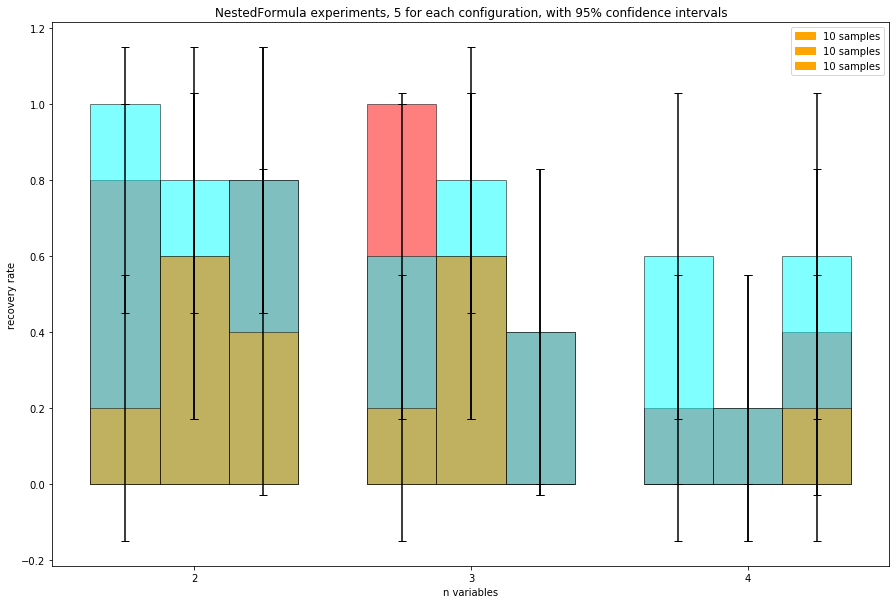

In [58]:
barwidth = 1/6
a = np.arange(-1, 2) / 4
colors = {10: "orange", 100: "cyan", 1000: "red"}
patches = []        
plt.figure(figsize=(15, 10))
for n_variables in range(2, 5):
    for m_samples in [1000, 100, 10]:
        plt.bar(a + n_variables, results[m_samples][n_variables], width=1/4, yerr=1.96 * se[m_samples][n_variables],
                color=colors[m_samples], edgecolor = 'black', capsize=4, alpha=0.5)   
    patches.append(mpatches.Patch(color=colors[m_samples], label=str(m_samples) + " samples"))
plt.xlabel('n variables')
plt.ylabel('recovery rate')
plt.xticks([2, 3, 4])
plt.title("NestedFormula experiments, 5 for each configuration, with 95% confidence intervals")
plt.legend(handles=patches)
plt.show()

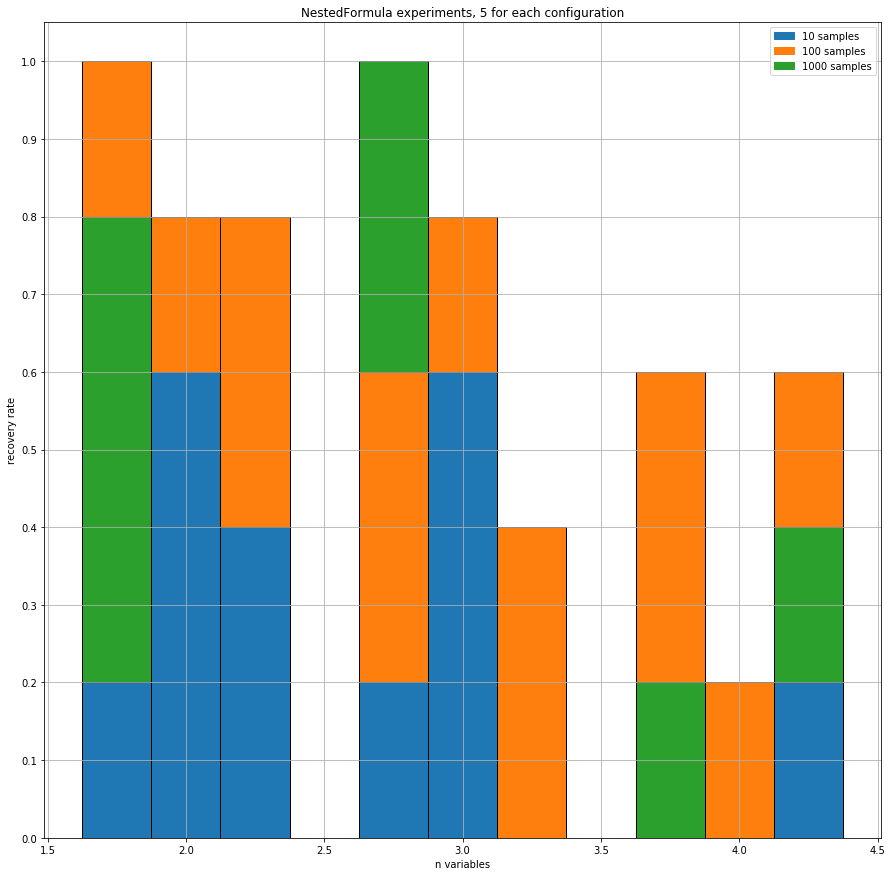

In [93]:
import matplotlib.pyplot as plt
import numpy as np
barwidth = 1/4
a = np.arange(-1, 2) / 4
colors = ['C0', 'C1', 'C2']
ecolors = ['C3', 'C4', 'C5']
# colors = [1, 2, 3]
patches = []        
plt.figure(figsize=(15, 15))
for i in range(3):
    patches.append(mpatches.Patch(color=colors[i], label=str(10**(i + 1)) + " samples"))
# n_variables = 4
# # for n_variables in range(2, 5):
# for powers_
# for m_samples in [1000, 100, 10]:
#     plt.bar(a + n_variables, results[m_samples][n_variables], width=1/4, yerr=1.96 * se[m_samples][n_variables],
#             color=colors[m_samples], edgecolor = 'black', capsize=4, alpha=0.5)   


for powers_type in range(3):    
    heights_a = [pd.DataFrame(results).loc[:, 10][i][powers_type] for i in (2, 3, 4)]
    heights_b = [pd.DataFrame(results).loc[:, 100][i][powers_type] for i in (2, 3, 4)]
    heights_c = [pd.DataFrame(results).loc[:, 1000][i][powers_type] for i in (2, 3, 4)]
    
    se_a = [pd.DataFrame(se).loc[:, 10][i][powers_type] for i in (2, 3, 4)]
    se_b = [pd.DataFrame(se).loc[:, 100][i][powers_type] for i in (2, 3, 4)]
    se_c = [pd.DataFrame(se).loc[:, 1000][i][powers_type] for i in (2, 3, 4)]
    

    position = np.arange(2, 5) + (powers_type - 1) / 4

    for x, ha, hb, hc, sea, seb, sec in zip(position, heights_a, heights_b, heights_c,
                                            se_a, se_b, se_c):
        for i, (h, serr, c, ec) in enumerate(sorted(zip([ha, hb, hc], [sea, seb, sec], colors, ecolors))):
            plt.bar(x, h,  color=c,  zorder=-i, width=barwidth, edgecolor = 'black')

plt.xlabel('n variables')
plt.ylabel('recovery rate')
# plt.xticks([2 - 0.25, 2, 2 + 0.25, 
#            3 - 0.25, 3, 3 + 0.25, 
#            4 - 0.25, 4, 4 + 0.25], 
#            ["integer powers", "half-integer\n powers\n2", "powers with \ndenominator 12",
#            "integer powers", "half-integer\n powers\n3", "powers with \ndenominator 12"
#            "integer powers", "half-integer\n powers\n4", "powers with \ndenominator 12"])
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
plt.title("NestedFormula experiments, 5 for each configuration")
plt.legend(handles=patches)
plt.show()

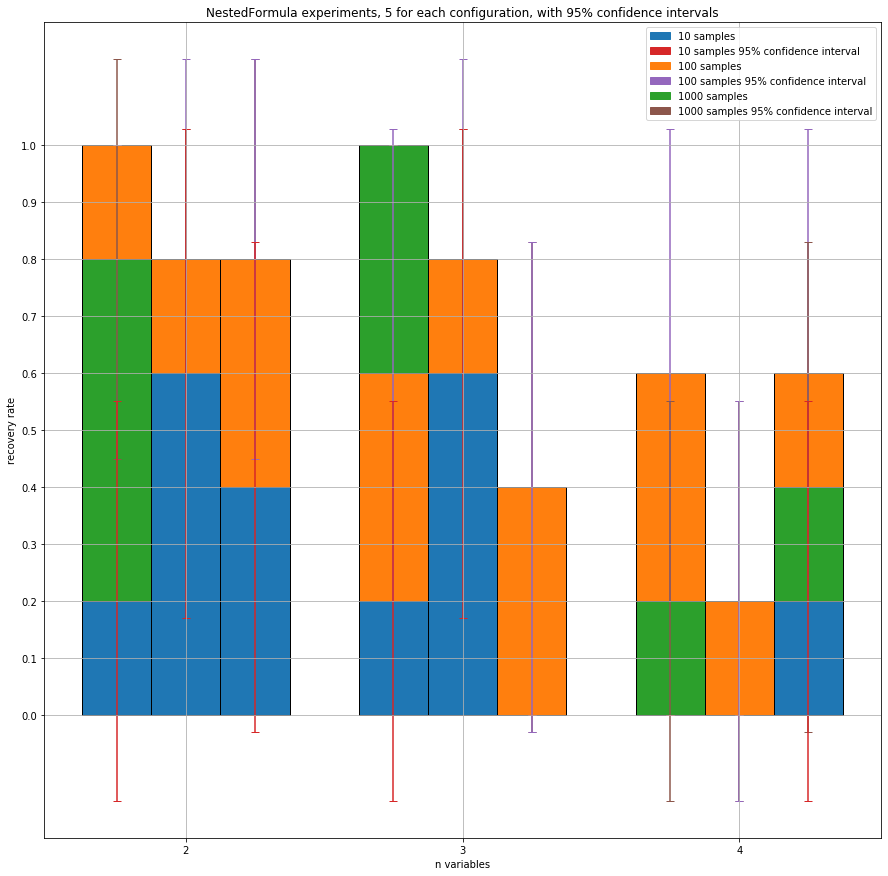

In [94]:
import matplotlib.pyplot as plt
import numpy as np
barwidth = 1/4
a = np.arange(-1, 2) / 4
colors = ['C0', 'C1', 'C2']
ecolors = ['C3', 'C4', 'C5']
# colors = [1, 2, 3]
patches = []        
plt.figure(figsize=(15, 15))
for i in range(3):
    patches.append(mpatches.Patch(color=colors[i], label=str(10**(i + 1)) + " samples"))
    patches.append(mpatches.Patch(color=ecolors[i], label=str(10**(i + 1)) + " samples 95% confidence interval"))
# n_variables = 4
# # for n_variables in range(2, 5):
# for powers_
# for m_samples in [1000, 100, 10]:
#     plt.bar(a + n_variables, results[m_samples][n_variables], width=1/4, yerr=1.96 * se[m_samples][n_variables],
#             color=colors[m_samples], edgecolor = 'black', capsize=4, alpha=0.5)   


for powers_type in range(3):    
    heights_a = [pd.DataFrame(results).loc[:, 10][i][powers_type] for i in (2, 3, 4)]
    heights_b = [pd.DataFrame(results).loc[:, 100][i][powers_type] for i in (2, 3, 4)]
    heights_c = [pd.DataFrame(results).loc[:, 1000][i][powers_type] for i in (2, 3, 4)]
    
    se_a = [pd.DataFrame(se).loc[:, 10][i][powers_type] for i in (2, 3, 4)]
    se_b = [pd.DataFrame(se).loc[:, 100][i][powers_type] for i in (2, 3, 4)]
    se_c = [pd.DataFrame(se).loc[:, 1000][i][powers_type] for i in (2, 3, 4)]
    

    position = np.arange(2, 5) + (powers_type - 1) / 4

    for x, ha, hb, hc, sea, seb, sec in zip(position, heights_a, heights_b, heights_c,
                                            se_a, se_b, se_c):
        for i, (h, serr, c, ec) in enumerate(sorted(zip([ha, hb, hc], [sea, seb, sec], colors, ecolors))):
            plt.bar(x, h, yerr=1.96 * serr, capsize=4, color=c, ecolor=ec, zorder=-i, width=barwidth, edgecolor = 'black')

plt.xlabel('n variables')
plt.ylabel('recovery rate')
plt.xticks([2, 3, 4])
plt.yticks(np.linspace(0, 1, 11))
plt.grid()
plt.title("NestedFormula experiments, 5 for each configuration, with 95% confidence intervals")
plt.legend(handles=patches)
plt.show()